In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules") 
from utils import dopioe, compute_tilt_data, bearing, ellipse_aspect_ratio

df_eddies = pd.read_pickle('/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Eddy_Data/df_eddies_processed_1462_10650.pkl')
df_eddies


Eddy    Day Cyc         Lon        Lat   ic   jc          xc  \
0          1   1462  CE  156.969773 -28.461100  179  274  505.897600   
1          1   1463  CE  156.993096 -28.433992  179  275  507.149717   
2          1   1464  CE  157.097940 -28.381485  181  276  515.130000   
3          1   1465  CE  157.094334 -28.315658  181  278  512.570772   
4          1   1466  CE  157.106324 -28.346479  181  277  514.728351   
...      ...    ...  ..         ...        ...  ...  ...         ...   
105233  2631  10646  AE  157.825620 -37.030656  248   97  850.502045   
105234  2631  10647  AE  157.880796 -36.972725  249   98  853.608024   
105235  2631  10648  AE  157.868516 -36.874363  248  100  849.759258   
105236  2631  10649  AE  157.753058 -36.882303  246   99  840.037603   
105237  2631  10650  AE  157.863435 -36.962331  248   98  851.818768   

                 yc         w       q11       q12       q22          Rc  \
0       1353.012251 -0.000033  1.099922 -0.193920  0.943344  104.677927   
1       1356.633687 -0.000030  1.066764 -0.119714  0.950849  110.542281   
2       1365.650728 -0.000028  1.016800 -0.154298  1.006892  115.245476   
3       1372.426342 -0.000033  0.896874 -0.276325  1.200119  114.738549   
4       1369.599726 -0.000029  0.847358 -0.169788  1.214160  100.425496   
...             ...       ...       ...       ...       ...         ...   
105233   476.447416  0.000013  0.898473  0.197470  1.156400  114.894173   
105234   484.316677  0.000014  0.884289  0.308226  1.238286  111.853372   
105235   494.400614  0.000014  0.883521  0.168561  1.163994  107.180060   
105236   489.981707  0.000013  0.873263  0.225002  1.203104  100.368133   
105237   484.885460  0.000014  0.910085  0.220492  1.152218  121.438271   

             psi0         A          R  Age       Date  \
0       71.391686 -0.006515  69.250036   57 1994-01-02   
1       77.351002 -0.006330  62.000626   57 1994-01-03   
2       75.250400 -0.005666  67.000485   57 1994-01-04   
3       72.789618 -0.005529  66.501582   57 1994-01-05   
4       58.705551 -0.005821  56.251116   57 1994-01-06   
...           ...       ...        ...  ...        ...   
105233 -41.491437  0.003143  72.751791   24 2019-02-24   
105234 -42.195517  0.003373  73.000933   24 2019-02-25   
105235 -43.102690  0.003752  75.750780   24 2019-02-26   
105236 -37.967048  0.003769  75.750006   24 2019-02-27   
105237 -47.159914  0.003198  68.750184   24 2019-02-28   

                                                    fname  
0       /srv/scratch/z3533156/26year_BRAN2020/outer_av...  
1       /srv/scratch/z3533156/26year_BRAN2020/outer_av...  
2       /srv/scratch/z3533156/26year_BRAN2020/outer_av...  
3       /srv/scratch/z3533156/26year_BRAN2020/outer_av...  
4       /srv/scratch/z3533156/26year_BRAN2020/outer_av...  
...                                                   ...  
105233  /srv/scratch/z3533156/26year_BRAN2020/outer_av...  
105234  /srv/scratch/z3533156/26year_BRAN2020/outer_av...  
105235  /srv/scratch/z3533156/26year_BRAN2020/outer_av...  
105236  /srv/scratch/z3533156/26year_BRAN2020/outer_av...  
105237  /srv/scratch/z3533156/26year_BRAN2020/outer_av...  

[105238 rows x 20 columns]

In [2]:
import netCDF4 as nc
from scipy.interpolate import griddata
import netCDF4 as nc
from scipy.interpolate import RegularGridInterpolator

# Field Data

fname = f'/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'

dataset = nc.Dataset(fname)

lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
mask_rho = np.transpose(dataset.variables['mask_rho'], axes=(1, 0))
h = np.transpose(dataset.variables['h'], axes=(1, 0))
# f = np.transpose(dataset.variables['f'], axes=(1, 0))
angle = dataset.variables['angle'][0, 0]
z_r = np.load('/srv/scratch/z5297792/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))

def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

j_mid = lon_rho.shape[1] // 2
i_mid = lon_rho.shape[0] // 2

dx = distance(lat_rho[:-1, j_mid], lon_rho[:-1, j_mid],
              lat_rho[1:, j_mid], lon_rho[1:, j_mid])
dy = distance(lat_rho[i_mid, :-1], lon_rho[i_mid, :-1],
              lat_rho[i_mid, 1:], lon_rho[i_mid, 1:])

x_grid = np.insert(np.cumsum(dx), 0, 0)
y_grid = np.insert(np.cumsum(dy), 0, 0)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid, indexing='ij')

levels_lat = [-40, -35, -30, -25]
levels_lon = [150, 155, 160]


In [3]:
ncols, nrows = 3, 4
x_edges = np.linspace(X_grid.min(), X_grid.max(), ncols+1)
y_edges = np.linspace(Y_grid.min(), Y_grid.max(), nrows+1)

# compute bin indices
df_eddies['ix'] = np.digitize(df_eddies.xc, x_edges) - 1   # 0..ncols-1
df_eddies['iy'] = np.digitize(df_eddies.yc, y_edges) - 1   # 0..nrows-1

# remove out-of-range bins
df_eddies.loc[(df_eddies.ix < 0) | (df_eddies.ix >= ncols), 'ix'] = np.nan
df_eddies.loc[(df_eddies.iy < 0) | (df_eddies.iy >= nrows), 'iy'] = np.nan

# column labels (A,B,C,...)
col_labels = np.array(['A','B','C','D'])[:ncols]

# create "A1", "C4", etc.
mask = df_eddies.ix.notna() & df_eddies.iy.notna()
df_eddies.loc[mask, 'cell_label'] = (
    col_labels[df_eddies.loc[mask, 'ix'].astype(int)] +
    (df_eddies.loc[mask, 'iy'].astype(int) + 1).astype(str).values
)

df_eddies


Eddy    Day Cyc         Lon        Lat   ic   jc          xc  \
0          1   1462  CE  156.969773 -28.461100  179  274  505.897600   
1          1   1463  CE  156.993096 -28.433992  179  275  507.149717   
2          1   1464  CE  157.097940 -28.381485  181  276  515.130000   
3          1   1465  CE  157.094334 -28.315658  181  278  512.570772   
4          1   1466  CE  157.106324 -28.346479  181  277  514.728351   
...      ...    ...  ..         ...        ...  ...  ...         ...   
105233  2631  10646  AE  157.825620 -37.030656  248   97  850.502045   
105234  2631  10647  AE  157.880796 -36.972725  249   98  853.608024   
105235  2631  10648  AE  157.868516 -36.874363  248  100  849.759258   
105236  2631  10649  AE  157.753058 -36.882303  246   99  840.037603   
105237  2631  10650  AE  157.863435 -36.962331  248   98  851.818768   

                 yc         w  ...          Rc       psi0         A  \
0       1353.012251 -0.000033  ...  104.677927  71.391686 -0.006515   
1       1356.633687 -0.000030  ...  110.542281  77.351002 -0.006330   
2       1365.650728 -0.000028  ...  115.245476  75.250400 -0.005666   
3       1372.426342 -0.000033  ...  114.738549  72.789618 -0.005529   
4       1369.599726 -0.000029  ...  100.425496  58.705551 -0.005821   
...             ...       ...  ...         ...        ...       ...   
105233   476.447416  0.000013  ...  114.894173 -41.491437  0.003143   
105234   484.316677  0.000014  ...  111.853372 -42.195517  0.003373   
105235   494.400614  0.000014  ...  107.180060 -43.102690  0.003752   
105236   489.981707  0.000013  ...  100.368133 -37.967048  0.003769   
105237   484.885460  0.000014  ...  121.438271 -47.159914  0.003198   

                R  Age       Date  \
0       69.250036   57 1994-01-02   
1       62.000626   57 1994-01-03   
2       67.000485   57 1994-01-04   
3       66.501582   57 1994-01-05   
4       56.251116   57 1994-01-06   
...           ...  ...        ...   
105233  72.751791   24 2019-02-24   
105234  73.000933   24 2019-02-25   
105235  75.750780   24 2019-02-26   
105236  75.750006   24 2019-02-27   
105237  68.750184   24 2019-02-28   

                                                    fname   ix   iy cell_label  
0       /srv/scratch/z3533156/26year_BRAN2020/outer_av...  1.0  3.0         B4  
1       /srv/scratch/z3533156/26year_BRAN2020/outer_av...  1.0  3.0         B4  
2       /srv/scratch/z3533156/26year_BRAN2020/outer_av...  1.0  3.0         B4  
3       /srv/scratch/z3533156/26year_BRAN2020/outer_av...  1.0  3.0         B4  
4       /srv/scratch/z3533156/26year_BRAN2020/outer_av...  1.0  3.0         B4  
...                                                   ...  ...  ...        ...  
105233  /srv/scratch/z3533156/26year_BRAN2020/outer_av...  2.0  1.0         C2  
105234  /srv/scratch/z3533156/26year_BRAN2020/outer_av...  2.0  1.0         C2  
105235  /srv/scratch/z3533156/26year_BRAN2020/outer_av...  2.0  1.0         C2  
105236  /srv/scratch/z3533156/26year_BRAN2020/outer_av...  2.0  1.0         C2  
105237  /srv/scratch/z3533156/26year_BRAN2020/outer_av...  2.0  1.0         C2  

[105238 rows x 23 columns]

Calculate there vertical centers

In [4]:
with open('/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Eddy_Data/Vertical_Eddy_Dataset/dic_vert_eddies.pkl', 'rb') as f:
    dic_eddies_vert = pickle.load(f)


In [5]:
df_tilt_data = pd.read_pickle("/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Eddy_Data/Vertical_Eddy_Dataset/df_tilt_data.pkl")
df_tilt_data


Eddy    Day    TiltDis     TiltDir
0         1   1465  31.669332   89.546110
1         1   1466  33.600109   92.955602
2         1   1467  35.159201   96.662951
3         1   1468  35.643445  101.070039
4         1   1469  34.916207  105.866105
...     ...    ...        ...         ...
89447  2631  10643  10.685422  350.104683
89448  2631  10644  10.055826  348.769338
89449  2631  10645  11.563679  343.688930
89450  2631  10646  12.848125  334.097803
89451  2631  10647  13.627106  324.784689

[89452 rows x 4 columns]

In [6]:
df_eddies = df_eddies.merge(
    df_tilt_data[['Eddy', 'Day', 'TiltDis', 'TiltDir']],
    how='left',
    left_on=['Eddy', 'Day'],
    right_on=['Eddy', 'Day']
)
df_eddies


Eddy    Day Cyc         Lon        Lat   ic   jc          xc  \
0          1   1462  CE  156.969773 -28.461100  179  274  505.897600   
1          1   1463  CE  156.993096 -28.433992  179  275  507.149717   
2          1   1464  CE  157.097940 -28.381485  181  276  515.130000   
3          1   1465  CE  157.094334 -28.315658  181  278  512.570772   
4          1   1466  CE  157.106324 -28.346479  181  277  514.728351   
...      ...    ...  ..         ...        ...  ...  ...         ...   
105233  2631  10646  AE  157.825620 -37.030656  248   97  850.502045   
105234  2631  10647  AE  157.880796 -36.972725  249   98  853.608024   
105235  2631  10648  AE  157.868516 -36.874363  248  100  849.759258   
105236  2631  10649  AE  157.753058 -36.882303  246   99  840.037603   
105237  2631  10650  AE  157.863435 -36.962331  248   98  851.818768   

                 yc         w  ...         A          R  Age       Date  \
0       1353.012251 -0.000033  ... -0.006515  69.250036   57 1994-01-02   
1       1356.633687 -0.000030  ... -0.006330  62.000626   57 1994-01-03   
2       1365.650728 -0.000028  ... -0.005666  67.000485   57 1994-01-04   
3       1372.426342 -0.000033  ... -0.005529  66.501582   57 1994-01-05   
4       1369.599726 -0.000029  ... -0.005821  56.251116   57 1994-01-06   
...             ...       ...  ...       ...        ...  ...        ...   
105233   476.447416  0.000013  ...  0.003143  72.751791   24 2019-02-24   
105234   484.316677  0.000014  ...  0.003373  73.000933   24 2019-02-25   
105235   494.400614  0.000014  ...  0.003752  75.750780   24 2019-02-26   
105236   489.981707  0.000013  ...  0.003769  75.750006   24 2019-02-27   
105237   484.885460  0.000014  ...  0.003198  68.750184   24 2019-02-28   

                                                    fname   ix   iy  \
0       /srv/scratch/z3533156/26year_BRAN2020/outer_av...  1.0  3.0   
1       /srv/scratch/z3533156/26year_BRAN2020/outer_av...  1.0  3.0   
2       /srv/scratch/z3533156/26year_BRAN2020/outer_av...  1.0  3.0   
3       /srv/scratch/z3533156/26year_BRAN2020/outer_av...  1.0  3.0   
4       /srv/scratch/z3533156/26year_BRAN2020/outer_av...  1.0  3.0   
...                                                   ...  ...  ...   
105233  /srv/scratch/z3533156/26year_BRAN2020/outer_av...  2.0  1.0   
105234  /srv/scratch/z3533156/26year_BRAN2020/outer_av...  2.0  1.0   
105235  /srv/scratch/z3533156/26year_BRAN2020/outer_av...  2.0  1.0   
105236  /srv/scratch/z3533156/26year_BRAN2020/outer_av...  2.0  1.0   
105237  /srv/scratch/z3533156/26year_BRAN2020/outer_av...  2.0  1.0   

        cell_label    TiltDis     TiltDir  
0               B4        NaN         NaN  
1               B4        NaN         NaN  
2               B4        NaN         NaN  
3               B4  31.669332   89.546110  
4               B4  33.600109   92.955602  
...            ...        ...         ...  
105233          C2  12.848125  334.097803  
105234          C2  13.627106  324.784689  
105235          C2        NaN         NaN  
105236          C2        NaN         NaN  
105237          C2        NaN         NaN  

[105238 rows x 25 columns]

In [7]:
num_profiles = len(df_eddies)-6*len(df_eddies.Eddy.unique())
print(f'Total No. of used profiles: {num_profiles}')
num_tilt_profiles = np.sum(~np.isnan(df_eddies.TiltDis))
print(f'Total No. of profiles tilt measured: {num_tilt_profiles}')
print(f'Tilt measuring success rate: {num_tilt_profiles/num_profiles}')


Total No. of used profiles: 89452
Total No. of profiles tilt measured: 74927
Tilt measuring success rate: 0.8376224120198542


In [8]:
df_tilt_data_clean = df_tilt_data.dropna().copy()
num_prof_TD_blw_40 = np.sum(df_tilt_data_clean.TiltDis <= 40) / num_tilt_profiles
print(f'No. Profiles below 40km TD: {num_prof_TD_blw_40}')
print(f'Max TD {df_tilt_data_clean.TiltDis.max()}')


No. Profiles below 40km TD: 0.8548053438680315
Max TD 152.19576956146645


#### Additional Data

In [9]:
def coriolis(lat_deg):
    Omega = 7.2921e-5  # Earth's rotation rate [rad/s]
    return 2 * Omega * np.sin(np.deg2rad(lat_deg))
df_eddies['f'] = coriolis(df_eddies.Lat)

day_idxs = []
for eddy in df_eddies.Eddy.unique():
    df = df_eddies[df_eddies.Eddy==eddy].copy()
    if len(df):
        day_idxs.extend(df.Day-df.Day.iloc[0])
df_eddies['Day_idx'] = day_idxs

norm_time = []
for eddy in df_eddies.Eddy.unique():
    seg = df_eddies[df_eddies.Eddy == eddy]
    n = len(seg)
    norm_time.extend(np.arange(n) / n)
df_eddies['norm_time'] = norm_time

eddy_props = []
for eddy in df_eddies.Eddy.unique():
    df = df_eddies[df_eddies.Eddy==eddy].copy()
    eddy_props.extend(np.array(np.hypot(df.xc.diff(), df.yc.diff()) * 0.011574))
df_eddies['EddyProp'] = eddy_props

# bottom of eddy propogation
df_idx = df_eddies.set_index(['Eddy', 'Day'])
eddy_btm_prop = []
for eddy, dic in dic_eddies_vert.items():
    x_btms, y_btms = [], []
    eddy_id = int(eddy[4:])
    for day, df in dic.items():
        if len(df):
            data = df.iloc[-1]
            xc, yc = data.x, data.y
        else:
            day_id = int(day[3:])
            data = df_idx.loc[(eddy_id, day_id)]
            xc, yc = data.xc, data.yc
        x_btms.append(xc)
        y_btms.append(yc)
    disp = np.hypot(np.diff(x_btms), np.diff(y_btms)) * 0.011574
    disp = np.insert(disp, 0, np.nan)   # add NaN at the start
    eddy_btm_prop.extend(disp)
df_eddies['btm_prop'] = eddy_btm_prop

ARs = []
for k in range(len(df_eddies)):
    data = df_eddies.iloc[k]
    ARs.append(ellipse_aspect_ratio(data.q11, data.q12, data.q22))
df_eddies['AR'] = ARs

hs = []
for k in range(len(df_eddies)):
    data = df_eddies.iloc[k]
    hs.append(h[data.ic, data.jc])
df_eddies['h'] = hs

def slope_mag(h, X, Y, mask=None):
    # derivatives wrt index space (i, j)
    x_i, x_j = np.gradient(X)
    y_i, y_j = np.gradient(Y)
    h_i, h_j = np.gradient(h)
    # Jacobian and physical-space gradients
    J = x_i*y_j - x_j*y_i
    dhdx = ( h_i*y_j - h_j*y_i) / J
    dhdy = (-h_i*x_j + h_j*x_i) / J
    S = np.hypot(dhdx, dhdy)          # slope magnitude = tan(theta)
    S[np.isclose(J, 0)] = np.nan       # guard against singular cells
    if mask is not None:               # mask: 1=ocean, 0=land
        S = np.where(mask.astype(bool), S, np.nan)
    return S
s = slope_mag(h/1e3, X_grid, Y_grid, mask=mask_rho)
df_eddies['s'] = s[df_eddies.ic, df_eddies.jc]

# Burger Number
H = 300
Nbar_ave = np.load('/srv/scratch/z5297792/Climatology/N2s/Nbar_300m_ave.npy')
f = np.transpose(dataset.variables['f'], axes=(1, 0))
Bu = ( (Nbar_ave * H) / (f * 50000) )**2
Bu = np.where(mask_rho, Bu, np.nan)
Bu = np.where(h > H, Bu, np.nan)
Bus = []
for k in range(len(df_eddies)):
    data = df_eddies.iloc[k]
    Bus.append(Bu[data.ic, data.jc])
df_eddies['Bu'] = Bus


### Latitude Analysis

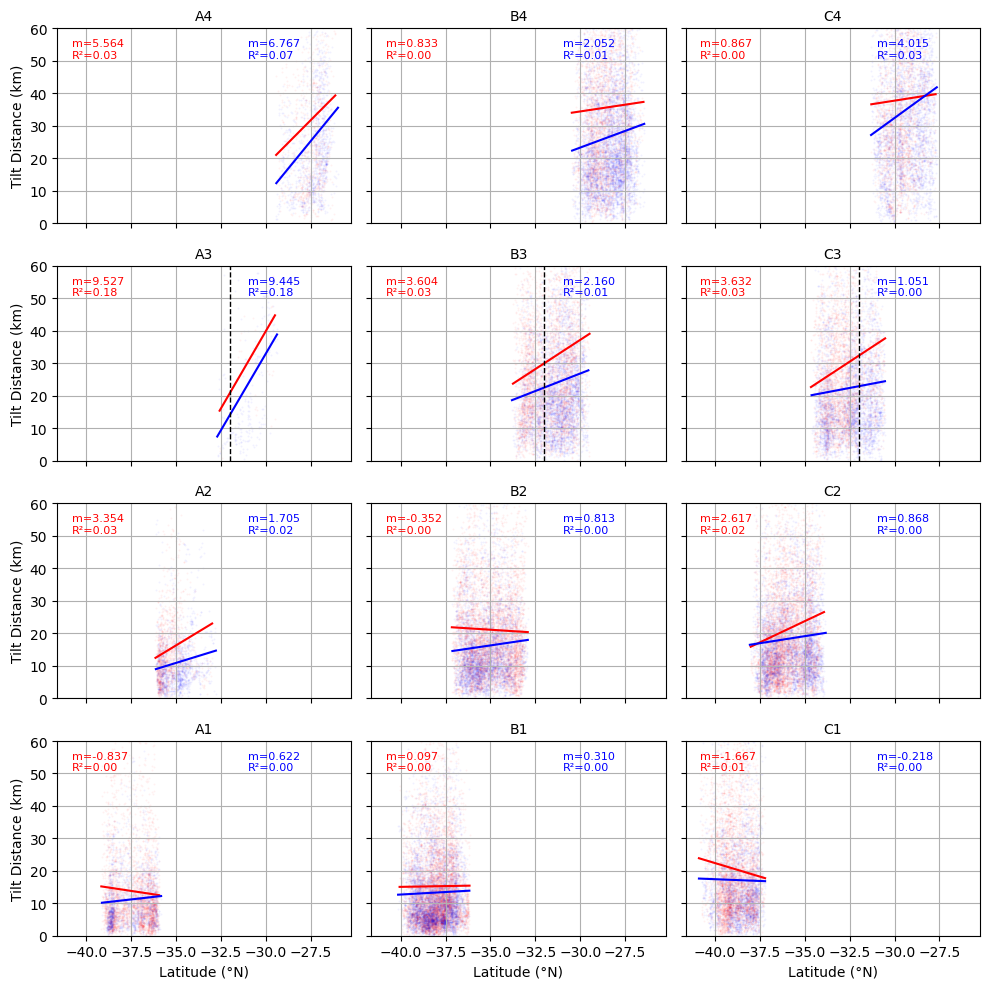

In [10]:
from scipy.stats import linregress

fig, axs = plt.subplots(4, 3, figsize=(10, 10), sharex=True, sharey=True)

cols = ['A', 'B', 'C']
rows = [4, 3, 2, 1]  # top to bottom
clrs = ['r', 'b']
for i, row in enumerate(rows):
    for j, col in enumerate(cols):
        ax = axs[i, j]
        lab = f'{col}{row}'
        sub_all = df_eddies[df_eddies.cell_label == lab].dropna(subset=['TiltDis', 'Lat'])

        for s, sub in enumerate([sub_all[sub_all.Cyc=='AE'], sub_all[sub_all.Cyc=='CE']]):
    
            if len(sub) > 1:
                x = sub.Lat.values
                y = sub.TiltDis.values
    
                slope, intercept, r, p, std_err = linregress(x, y)
    
                ax.scatter(x, y, s=1, marker='.', alpha=.05, color=clrs[s])
                xx = np.linspace(x.min(), x.max(), 50)
                ax.plot(xx, slope*xx + intercept, color=clrs[s])
    
                ax.text(
                    0.05 + s*.6, 0.95,
                    f"m={slope:.3f}\nR²={r**2:.2f}",
                    transform=ax.transAxes, color=clrs[s],
                    ha='left', va='top', fontsize=8
                )

        ax.set_title(lab, fontsize=10); ax.grid(True)

        if row == 3:
            ax.axvline(x=-32, ls='--', lw=1, color='k')

for ax in axs[-1, :]:
    ax.set_xlabel('Latitude (°N)')
    ax.set_ylim(0, 60)
for ax in axs[:, 0]:
    ax.set_ylabel('Tilt Distance (km)')

plt.tight_layout()
plt.show()


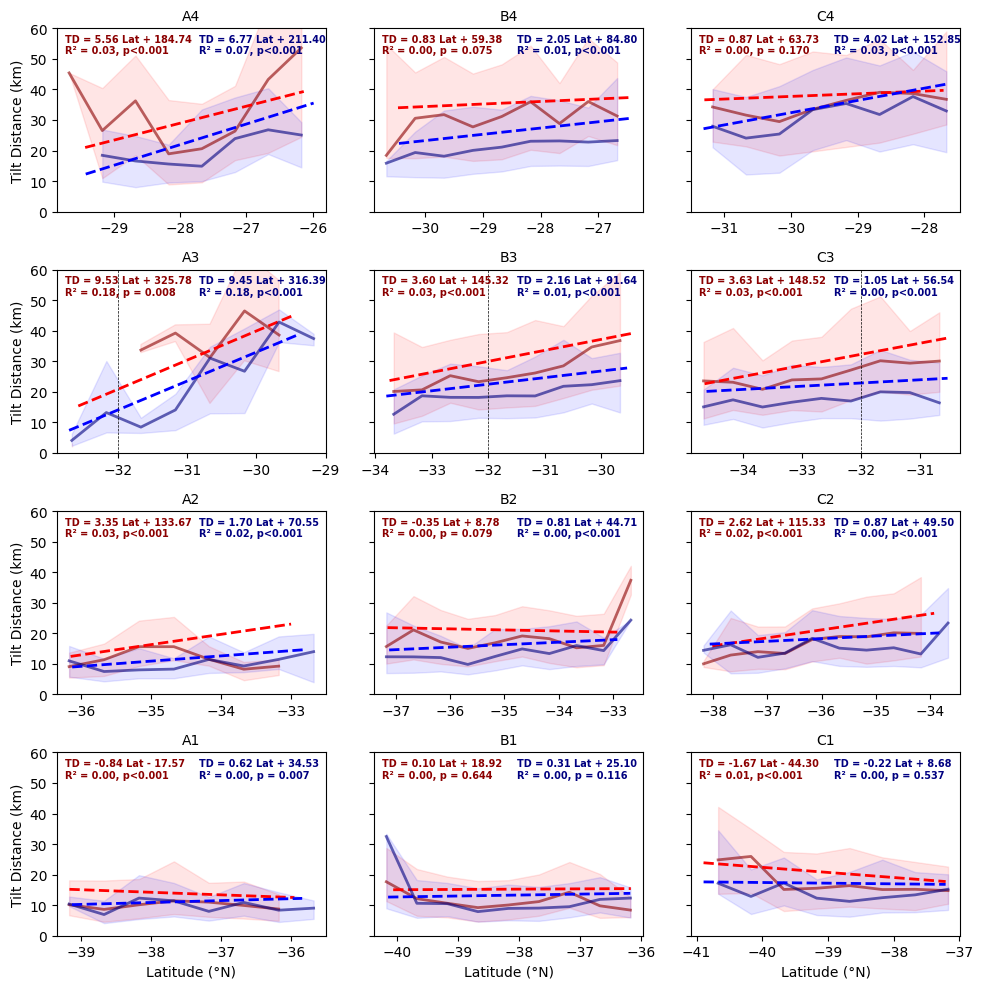

In [11]:
from scipy.stats import linregress

fig, axs = plt.subplots(4, 3, figsize=(10, 10), sharex=False, sharey=True)

cols = ['A', 'B', 'C']
rows = [4, 3, 2, 1]  # top to bottom

styles = {
    'AE': {'line': 'darkred', 'fill': 'red'},
    'CE': {'line': 'navy',    'fill': 'blue'}
}

lat_min = df_eddies.Lat.min()
lat_max = df_eddies.Lat.max()
bins = np.arange(lat_min, lat_max + 1, .5)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

for i, row in enumerate(rows):
    for j, col in enumerate(cols):
        ax = axs[i, j]
        lab = f'{col}{row}'
        sub_all = df_eddies[df_eddies.cell_label == lab].dropna(subset=['TiltDis', 'Lat'])

        for cyc in ['AE', 'CE']:
            sub = sub_all[sub_all.Cyc == cyc]
            if len(sub) < 2:
                continue

            lat = sub['Lat'].values
            tilt = sub['TiltDis'].values

            digitized = np.digitize(lat, bins)

            median = [np.median(tilt[digitized == k]) if np.any(digitized == k) else np.nan
                      for k in range(1, len(bins))]
            q25    = [np.quantile(tilt[digitized == k], 0.25) if np.any(digitized == k) else np.nan
                      for k in range(1, len(bins))]
            q75    = [np.quantile(tilt[digitized == k], 0.75) if np.any(digitized == k) else np.nan
                      for k in range(1, len(bins))]

            ax.plot(bin_centers, median,
                    color=styles[cyc]['line'], lw=2, alpha=0.6)
            ax.fill_between(bin_centers, q25, q75,
                            color=styles[cyc]['fill'], alpha=0.1)

            slope, intercept, r, p, std_err = linregress(lat, tilt)
            lat_line = np.linspace(lat.min(), lat.max(), 100)
            tilt_line = slope * lat_line + intercept
            ax.plot(lat_line, tilt_line,
                    lw=2, linestyle='--', color=styles[cyc]['fill'])

            if intercept >= 0:
                eq_str = f'TD = {slope:.2f} Lat + {intercept:.2f}'
            else:
                eq_str = f'TD = {slope:.2f} Lat - {abs(intercept):.2f}'
            p_str = 'p<0.001' if p < 0.001 else f'p = {p:.3f}'
            r2 = r**2

            x_text = 0.03 if cyc == 'AE' else 0.53
            ax.text(
                x_text, 0.97,
                f'{eq_str}\nR² = {r2:.2f}, {p_str}',
                transform=ax.transAxes,
                ha='left', va='top',
                fontsize=7,
                color=styles[cyc]['line'],
                fontweight='bold'
            )

        ax.set_title(lab, fontsize=10)
        # ax.grid(True)

        if row == 3:
            ax.axvline(x=-32, ls='--', lw=.5, color='k')

for ax in axs[-1, :]:
    ax.set_xlabel('Latitude (°N)')
    ax.set_ylim(0, 60)

for ax in axs[:, 0]:
    ax.set_ylabel('Tilt Distance (km)')

plt.tight_layout()
plt.show()



### Stratification

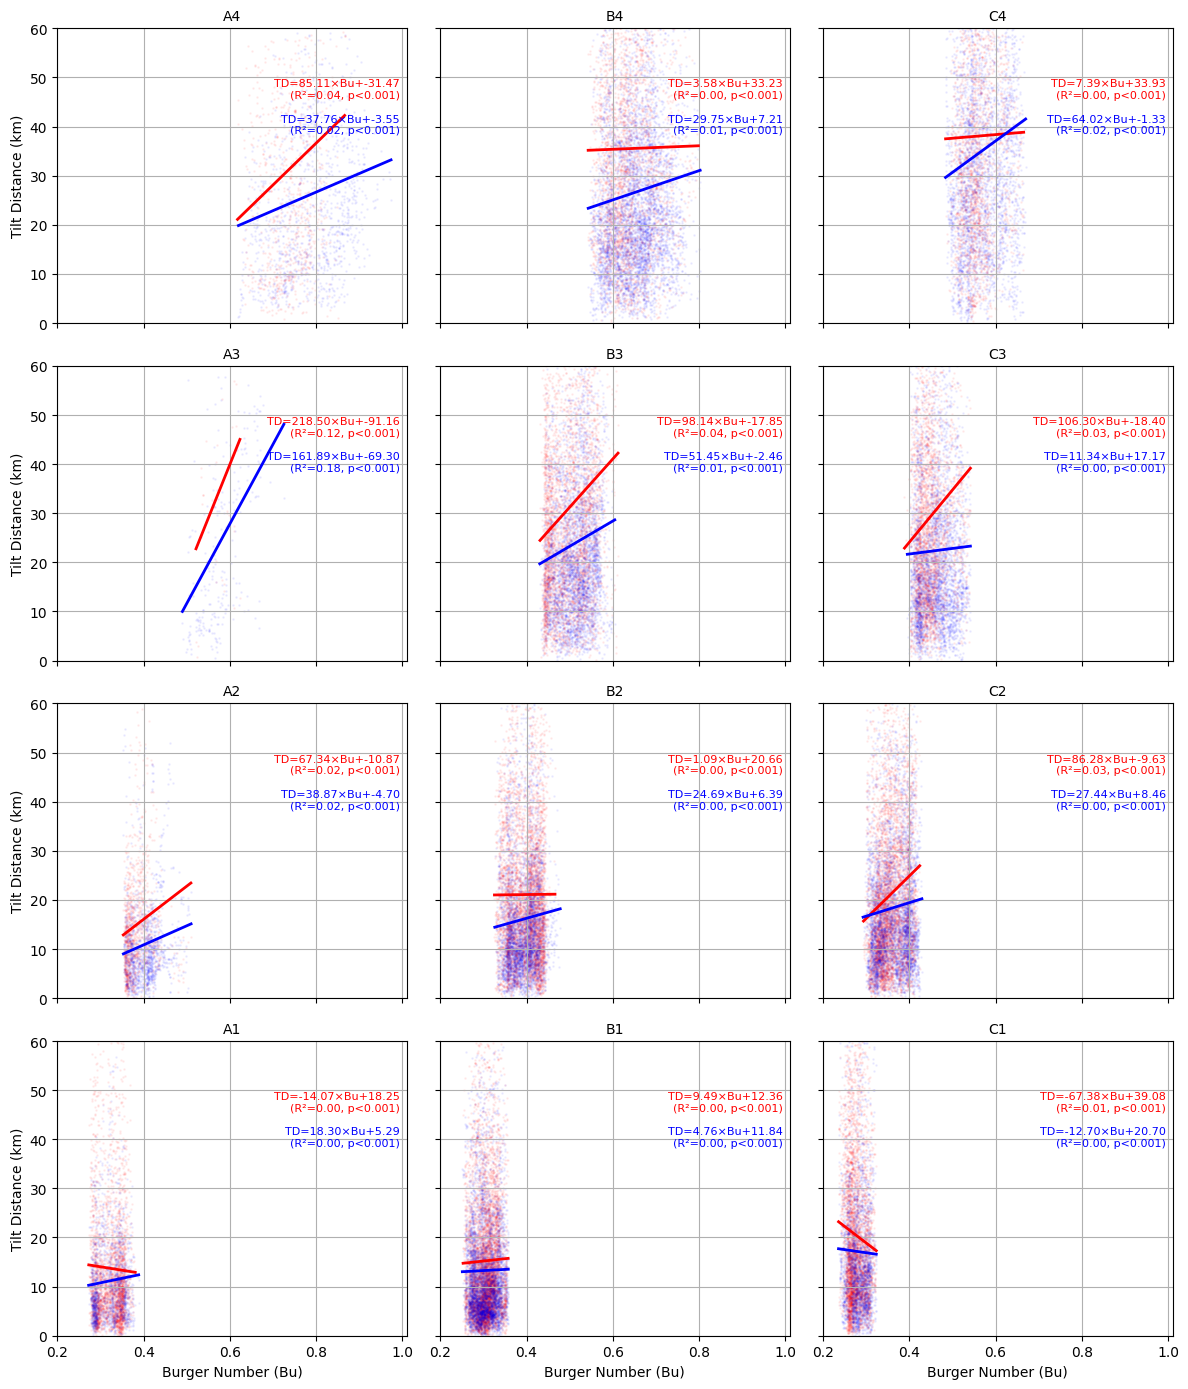

In [12]:
from scipy.stats import linregress

rows = [4, 3, 2, 1]          # top → bottom
cols = ['A', 'B', 'C']       # left → right

clrs = ['k', 'r', 'b']
labels = ['AE & CE', 'AE', 'CE']

fig, axs = plt.subplots(4, 3, figsize=(12, 14), sharex=True, sharey=True)

for i, row in enumerate(rows):
    for j, col in enumerate(cols):
        ax = axs[i, j]

        lab = f"{col}{row}"
        ax.set_title(lab, fontsize=10)

        df_all = df_eddies[df_eddies.cell_label == lab].copy()
        df_AE  = df_all[df_all.Cyc == 'AE'].copy()
        df_CE  = df_all[df_all.Cyc == 'CE'].copy()

        dfs = [df_all, df_AE, df_CE]

        for k, df in enumerate(dfs):
            if k != 0:
                if len(df) < 2:
                    continue
    
                x = df.Bu.values
                y = df.TiltDis.values
    
                mask = ~np.isnan(x) & ~np.isnan(y)
                x = x[mask]
                y = y[mask]
    
                if len(x) < 2:
                    continue
    
                res = linregress(x, y)
                slope, intercept = res.slope, res.intercept
                r2, p = res.rvalue**2, res.pvalue
    
                # scatter only for AE&CE
                if k != 0:
                    ax.scatter(x, y, s=1, alpha=.05, color=clrs[k])
    
                # regression line
                idx = np.argsort(x)
                xs = x[idx]
                ax.plot(xs, slope*xs + intercept,
                        color=clrs[k], lw=2, ls='-')
    
                # text annotation (same format as your original)
                ax.text(
                    0.98, 0.95 - 0.12*k,
                    fr"TD={slope:.2f}×Bu+{intercept:.2f}"
                    f"\n(R²={r2:.2f}, p<0.001)",
                    ha='right', va='top',
                    color=clrs[k], transform=ax.transAxes, fontsize=8
                )
                ax.grid(True)

# axis labels
for ax in axs[-1, :]:
    ax.set_xlabel('Burger Number (Bu)')
    ax.set_ylim(0, 60)
for ax in axs[:, 0]:
    ax.set_ylabel('Tilt Distance (km)')

plt.tight_layout()
plt.show()


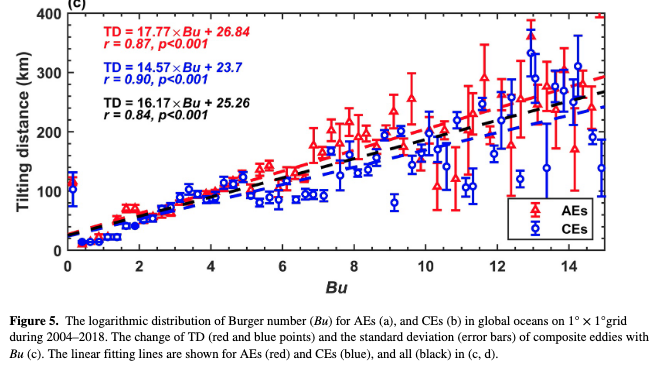





### Time Analysis

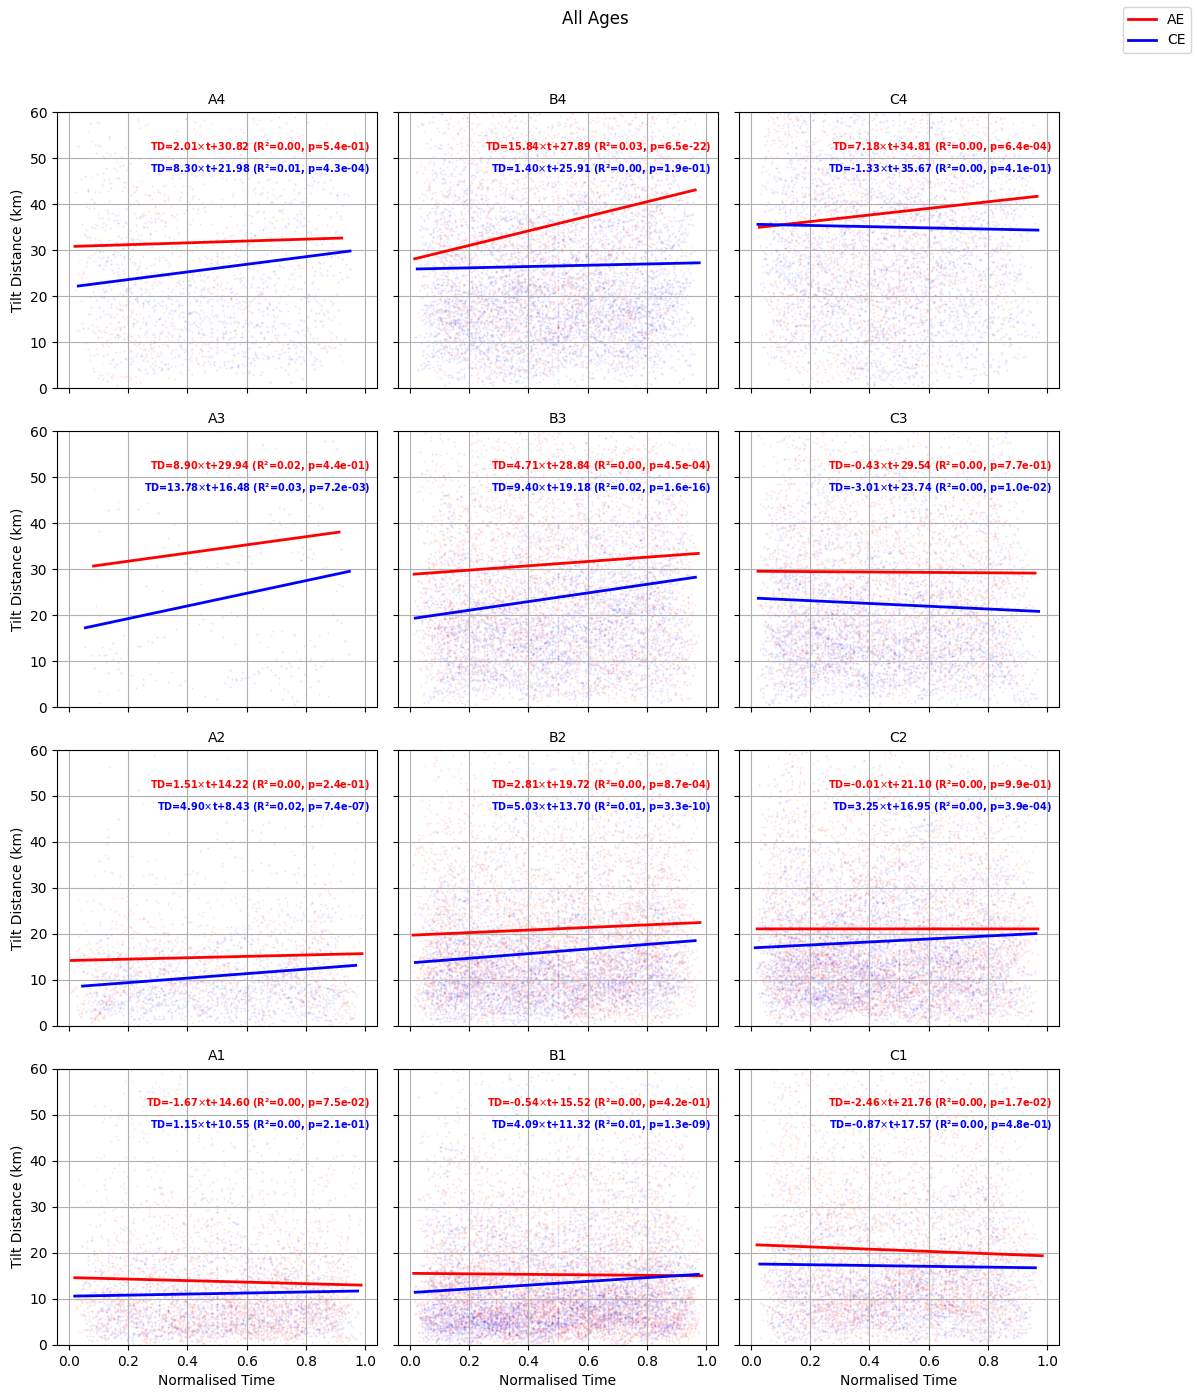

In [13]:
from scipy.stats import linregress

rows = [4, 3, 2, 1]      # top → bottom
cols = ['A', 'B', 'C']   # left → right

titles = ['ALL', 'AE', 'CE']
clrs   = ['k', 'r', 'b']

fig, axs = plt.subplots(4, 3, figsize=(12, 14), sharex=True, sharey=True)

for i, row in enumerate(rows):
    for j, col in enumerate(cols):
        ax = axs[i, j]
        lab = f'{col}{row}'
        ax.set_title(lab, fontsize=10)

        # restrict to this domain
        df_all = df_eddies[df_eddies.cell_label == lab].copy()
        df_AE  = df_all[df_all.Cyc == 'AE'].copy()
        df_CE  = df_all[df_all.Cyc == 'CE'].copy()

        for d, df_data in enumerate([df_all, df_AE, df_CE]):
            if d != 0:
                if df_data.empty:
                    continue
    
                # build x,y as in your code (per eddy)
                df_list = []
                for eddy in df_data.Eddy.unique():
                    seg = df_data[df_data.Eddy == eddy]
                    df_list.append(pd.DataFrame({
                        'x': seg.norm_time,
                        'y': seg.TiltDis
                    }))
    
                df = pd.concat(df_list, ignore_index=True).dropna()
                if len(df) < 2:
                    continue
    
                x, y = df.x.values, df.y.values
                slope, intercept, r, p, err = linregress(x, y)
                r2 = r**2
    
                if d != 0:
                    ax.scatter(x, y, s=1, marker='.', alpha=.1, color=clrs[d])
    
                idx = np.argsort(x)
                xs = x[idx]
                ax.plot(xs, slope * xs + intercept, color=clrs[d], lw=2, label=titles[d])
    
                txt = fr"TD={slope:.2f}$\times$t+{intercept:.2f} (R²={r2:.2f}, p={p:.1e})"
                ax.text(0.98, 0.98 - .08*d, txt, ha='right', va='top',
                        fontweight='bold', color=clrs[d], transform=ax.transAxes, fontsize=7)

# labels / limits
for ax in axs[-1, :]:
    ax.set_xlabel('Normalised Time')
for ax in axs[:, 0]:
    ax.set_ylabel('Tilt Distance (km)')

for ax in axs.ravel():
    ax.set_ylim(0, 60)
    ax.grid(True)

handles, labels = axs[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

plt.suptitle('All Ages', y=0.995)
plt.tight_layout(rect=[0, 0, 0.9, 0.97])
plt.show()


This doesnt really make sense, since it is not guaranteed the eddy stays in a particular bin. 






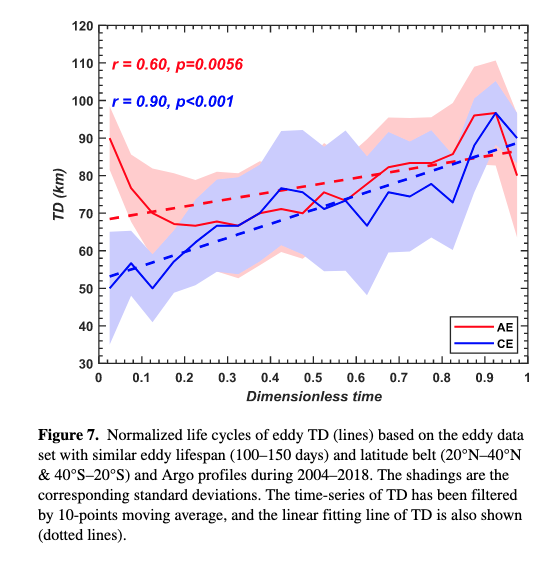

### Seasonality



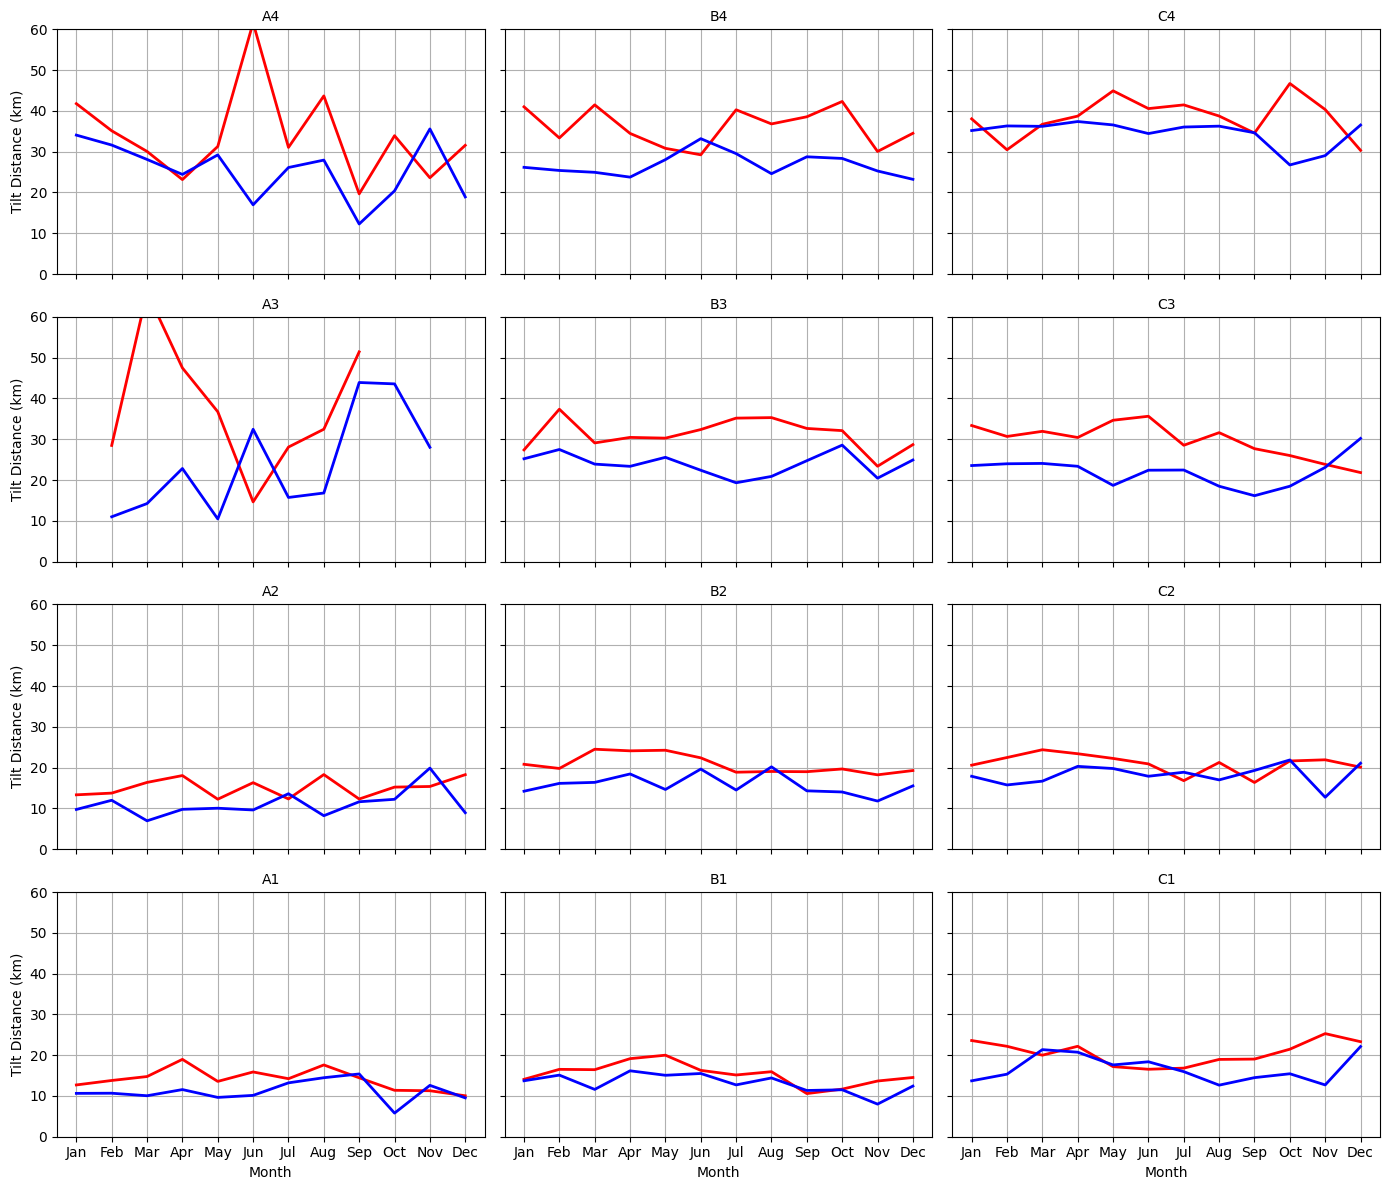

In [14]:
rows = [4, 3, 2, 1]
cols = ['A', 'B', 'C']

fig, axs = plt.subplots(4, 3, figsize=(14, 12), sharex=True, sharey=True)

month_labels = ['Jan','Feb','Mar','Apr','May','Jun',
                'Jul','Aug','Sep','Oct','Nov','Dec']

for i, row in enumerate(rows):
    for j, col in enumerate(cols):
        ax = axs[i, j]
        cell = f"{col}{row}"
        ax.set_title(cell, fontsize=10)

        df_cell = df_eddies[df_eddies.cell_label == cell]

        for label, c in [('AE', 'r'), ('CE', 'b')]:

            # FILTER FIRST → THEN .copy() BEFORE ANY ASSIGNMENT
            df = df_cell[df_cell.Cyc == label].copy()
            if df.empty:
                continue

            # SAFE: now df is a real copy, not a slice
            df['Month'] = df['Date'].dt.month

            mean = df.groupby('Month').TiltDis.mean()

            ax.plot(mean.index, mean.values, lw=2, color=c)

        ax.set_xticks(range(1, 13))
        ax.grid(True)
        ax.set_ylim(0, 60)

# Axis labels
for ax in axs[-1, :]:
    ax.set_xticklabels(month_labels)
    ax.set_xlabel('Month')

for ax in axs[:, 0]:
    ax.set_ylabel('Tilt Distance (km)')

plt.tight_layout()
plt.show()


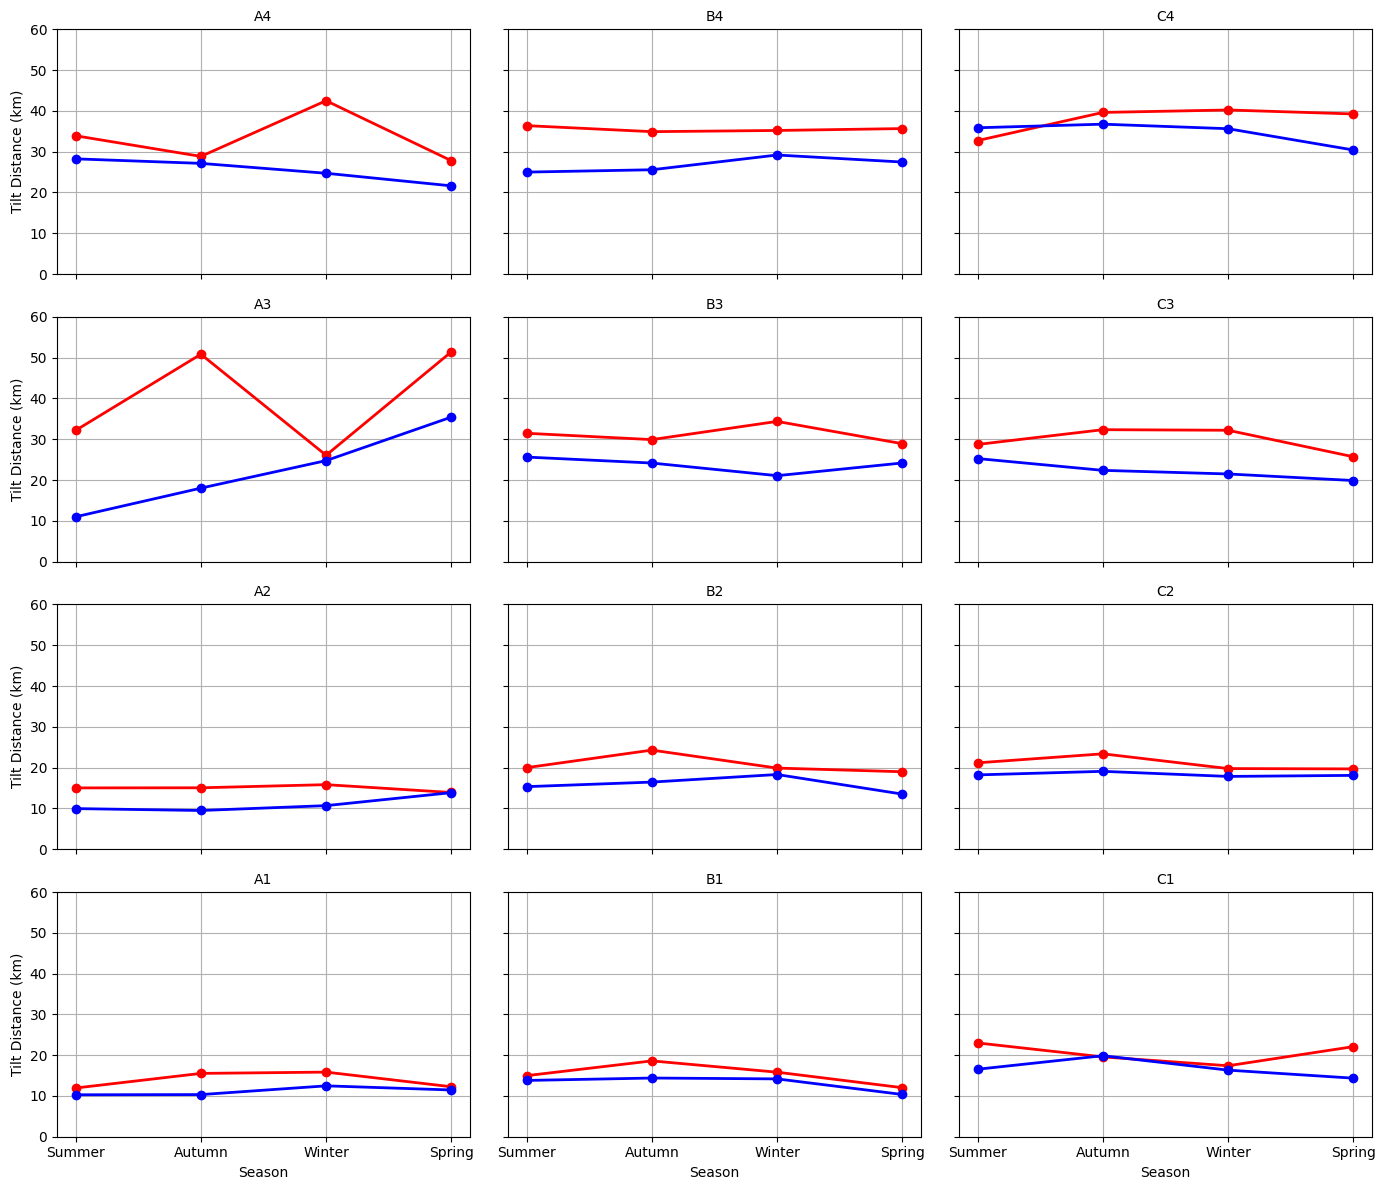

In [15]:
rows = [4, 3, 2, 1]
cols = ['A', 'B', 'C']

# Season mapping (Austral seasons)
season_map = {
    12:'Summer', 1:'Summer', 2:'Summer',
    3:'Autumn', 4:'Autumn', 5:'Autumn',
    6:'Winter', 7:'Winter', 8:'Winter',
    9:'Spring',10:'Spring',11:'Spring'
}
season_order = ['Summer', 'Autumn', 'Winter', 'Spring']

fig, axs = plt.subplots(4, 3, figsize=(14, 12), sharex=True, sharey=True)

for i, row in enumerate(rows):
    for j, col in enumerate(cols):
        ax = axs[i, j]
        cell = f"{col}{row}"
        ax.set_title(cell, fontsize=10)

        df_cell = df_eddies[df_eddies.cell_label == cell]

        for label, c in [('AE', 'r'), ('CE', 'b')]:

            # FILTER FIRST → THEN copy() (prevents SettingWithCopyWarning)
            df = df_cell[df_cell.Cyc == label].copy()
            if df.empty:
                continue

            # Add season safely
            df['Season'] = df['Date'].dt.month.map(season_map)
            df['Season'] = pd.Categorical(
                df['Season'], categories=season_order, ordered=True
            )

            # Seasonal mean
            mean = (
                df.groupby('Season', observed=True)
                  .TiltDis.mean()
                  .reindex(season_order)
            )

            x = np.arange(len(season_order))
            ax.plot(x, mean.values, lw=2, marker='o', color=c)

        ax.set_xticks(np.arange(len(season_order)))
        ax.set_xticklabels(season_order, rotation=0)
        ax.grid(True)
        ax.set_ylim(0, 60)

# Axis labels
for ax in axs[:, 0]:
    ax.set_ylabel('Tilt Distance (km)')
for ax in axs[-1, :]:
    ax.set_xlabel('Season')

plt.tight_layout()
plt.show()


### Temperature

### Windrose

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


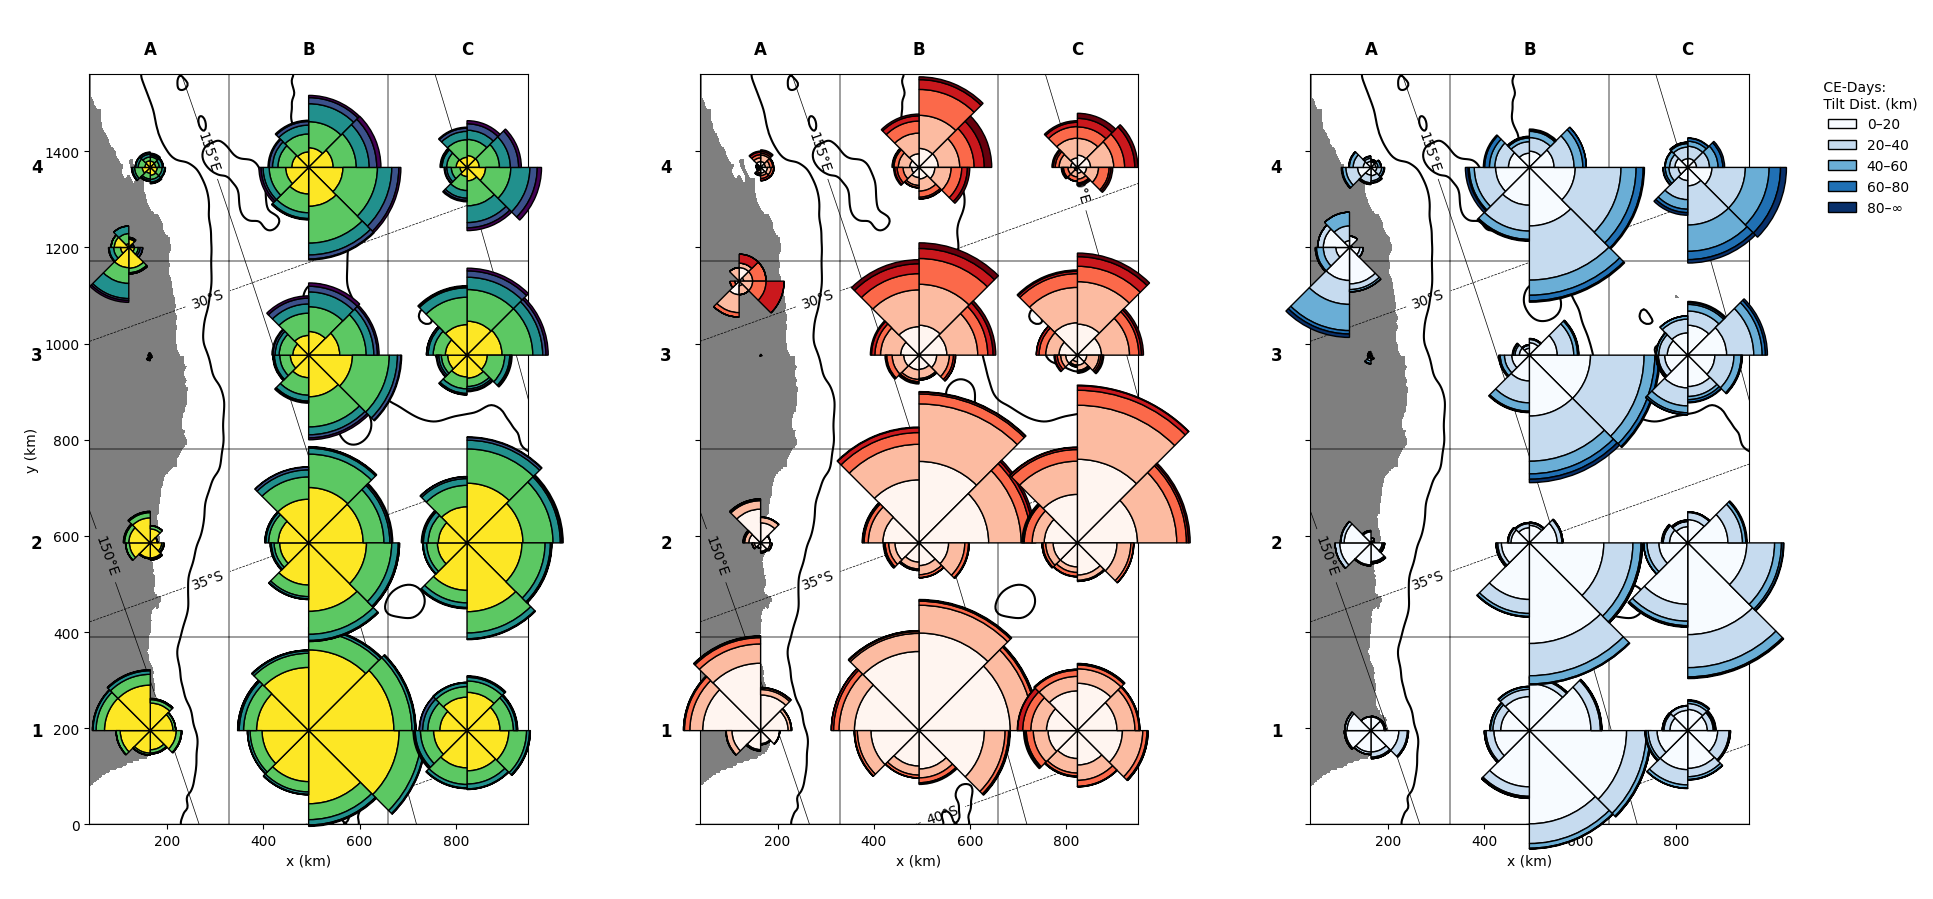

In [16]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

ncols, nrows = 3, 4
x_edges = np.linspace(X_grid.min(), X_grid.max(), ncols+1)
y_edges = np.linspace(Y_grid.min(), Y_grid.max(), nrows+1)
cell_w = (X_grid.max() - X_grid.min())/ncols
cell_h = (Y_grid.max() - Y_grid.min())/nrows

dir_bins = np.linspace(0, 360, 9)
mag_bins = [0, 20, 40, 60, 80, np.inf]
n_dirs = len(dir_bins) - 1
angles = np.deg2rad((dir_bins[:-1] + dir_bins[1:]) / 2)
width = 2*np.pi / n_dirs
colors_cmps = [plt.cm.viridis_r(np.linspace(0, 1, len(mag_bins)-1)),
               plt.cm.Reds(np.linspace(0, 1, len(mag_bins)-1)),
               plt.cm.Blues(np.linspace(0, 1, len(mag_bins)-1))]

# column labels for cell names
col_labels = ['A', 'B', 'C']  # matches ncols=3

def windrose_counts(directions, magnitudes):
    if len(directions) == 0:
        return None
    d = np.digitize(np.mod(directions, 360), dir_bins) - 1
    m = np.digitize(magnitudes, mag_bins) - 1
    c = np.zeros((len(mag_bins)-1, n_dirs))
    for di, mi in zip(d, m):
        if 0 <= di < n_dirs and 0 <= mi < len(mag_bins)-1:
            c[mi, di] += 1
    return c

def add_windrose(ax, x0, y0, c, rmax, colors, frac=0.45, tick_flag=False, title=''):
    if c is None:
        return
    s = frac * min(cell_w, cell_h)
    iax = ax.inset_axes([x0 - s/2, y0 - s/2, s, s], transform=ax.transData, projection='polar')
    bottom = np.zeros(n_dirs)
    for i in range(len(mag_bins)-1):
        hi = "∞" if np.isinf(mag_bins[i+1]) else f"{mag_bins[i+1]:g}"
        label = f"{mag_bins[i]:g}–{hi}"
        iax.bar(angles, c[i], width, bottom=bottom, edgecolor='k', color=colors[i], label=label)
        bottom += c[i]
    iax.set_theta_zero_location('N')
    iax.set_theta_direction(-1)
    iax.set_rlim(0, rmax)
    if tick_flag:
        iax.legend(title=title, loc='upper right', frameon=False,
                   fontsize=10, title_fontsize=10, bbox_to_anchor=(1.35, .85))
    iax.set_xticks([]); iax.set_yticks([]); iax.set_frame_on(False)
    return iax

# precompute counts per cell + global rmax, using cell_label instead of xc/yc binning
def cell_counts(df):
    out, rmax = {}, 0.0
    for i in range(ncols):
        for j in range(nrows):
            # j is 0..3 (bottom→top); your labels are 1..4 from bottom
            cell_name = f"{col_labels[i]}{j+1}"
            sub = df[df.cell_label == cell_name]

            d = np.asarray(sub.TiltDir.dropna().values, float)
            m = np.asarray(sub.TiltDis.dropna().values, float)
            n = min(len(d), len(m))
            c = windrose_counts(d[:n], m[:n])
            out[(i, j)] = c
            if c is not None:
                rmax = max(rmax, np.max(c.sum(axis=0)))
    return out, (1 if rmax == 0 else rmax)

fracs = [1.5, 2.0, 1.8]
fig, axs = plt.subplots(1, 3, figsize=(19, 9), sharey=True)
titles = ['Eddy-Days', 'AE-Days', 'CE-Days']

for p, cyc in enumerate(['AE & CE', 'AE', 'CE']):
    ax = axs[p]
    df = df_eddies if cyc == 'AE & CE' else df_eddies[df_eddies.Cyc == cyc]

    ax.contourf(X_grid, Y_grid, np.where(mask_rho == 0, 1, np.nan),
                levels=[0.5, 1.5], colors=['k'], alpha=.5)
    c1 = ax.contour(X_grid, Y_grid, lat_rho, levels=levels_lat,
                    colors='k', linewidths=.5)
    ax.clabel(c1, fmt=lambda v: f"{np.abs(v):.0f}°S", inline=True, colors='k')
    c2 = ax.contour(X_grid, Y_grid, lon_rho, levels=levels_lon,
                    colors='k', linewidths=.5)
    ax.clabel(c2, fmt=lambda v: f"{v:.0f}°E", inline=True, colors='k')
    ax.axis('equal')
    ax.set_xlim(X_grid.min(), X_grid.max())
    ax.set_ylim(Y_grid.min(), Y_grid.max())
    ax.contour(X_grid, Y_grid, h, levels=[4000], colors='k')

    counts_map, rmax = cell_counts(df)

    for i in range(ncols):
        for j in range(nrows):
            x0, x1 = x_edges[i], x_edges[i+1]
            y0, y1 = y_edges[j], y_edges[j+1]
            xc, yc = 0.5*(x0+x1), 0.5*(y0+y1)

            if (i == 2) and (j == 3) and (p == 2):
                tick_flag = True
            else:
                tick_flag = False

            add_windrose(ax, xc, yc, counts_map[(i, j)], rmax,
                         colors_cmps[p], frac=fracs[p],
                         tick_flag=tick_flag,
                         title=' ' + titles[p] + ':\n Tilt Dist. (km)')

            # example extra inset (unchanged)
            if (i == 0) and (j == 2):
                if p == 1:
                    add_windrose(ax, 120, 1130, counts_map[(i, j)],
                                 rmax/40, colors_cmps[p], frac=fracs[p])
                else:
                    add_windrose(ax, 120, 1200, counts_map[(i, j)],
                                 rmax/10, colors_cmps[p], frac=fracs[p])

            ax.plot([x0, x1, x1, x0, x0],
                    [y0, y0, y1, y1, y0], 'k-', lw=.3)

    # column headers above each column
    for i in range(ncols):
        xc = 0.5 * (x_edges[i] + x_edges[i+1])
        ax.text(xc, y_edges[-1] + 0.02*(Y_grid.max()-Y_grid.min()),
                col_labels[i], ha='center', va='bottom',
                fontsize=12, fontweight='bold')

    # row headers to the left of each row (counted from bottom: 1..4)
    for j in range(nrows):
        yc = 0.5 * (y_edges[j] + y_edges[j+1])
        alpha = .06 if p == 0 else .02
        ax.text(x_edges[0] - alpha*(X_grid.max()-X_grid.min()), yc,
                f"{j+1}", ha='right', va='center',
                fontsize=12, fontweight='bold')

for ax in axs:
    ax.set_xlabel('x (km)')
axs[0].set_ylabel('y (km)')

plt.tight_layout()
plt.show()



### Eddy Propogation

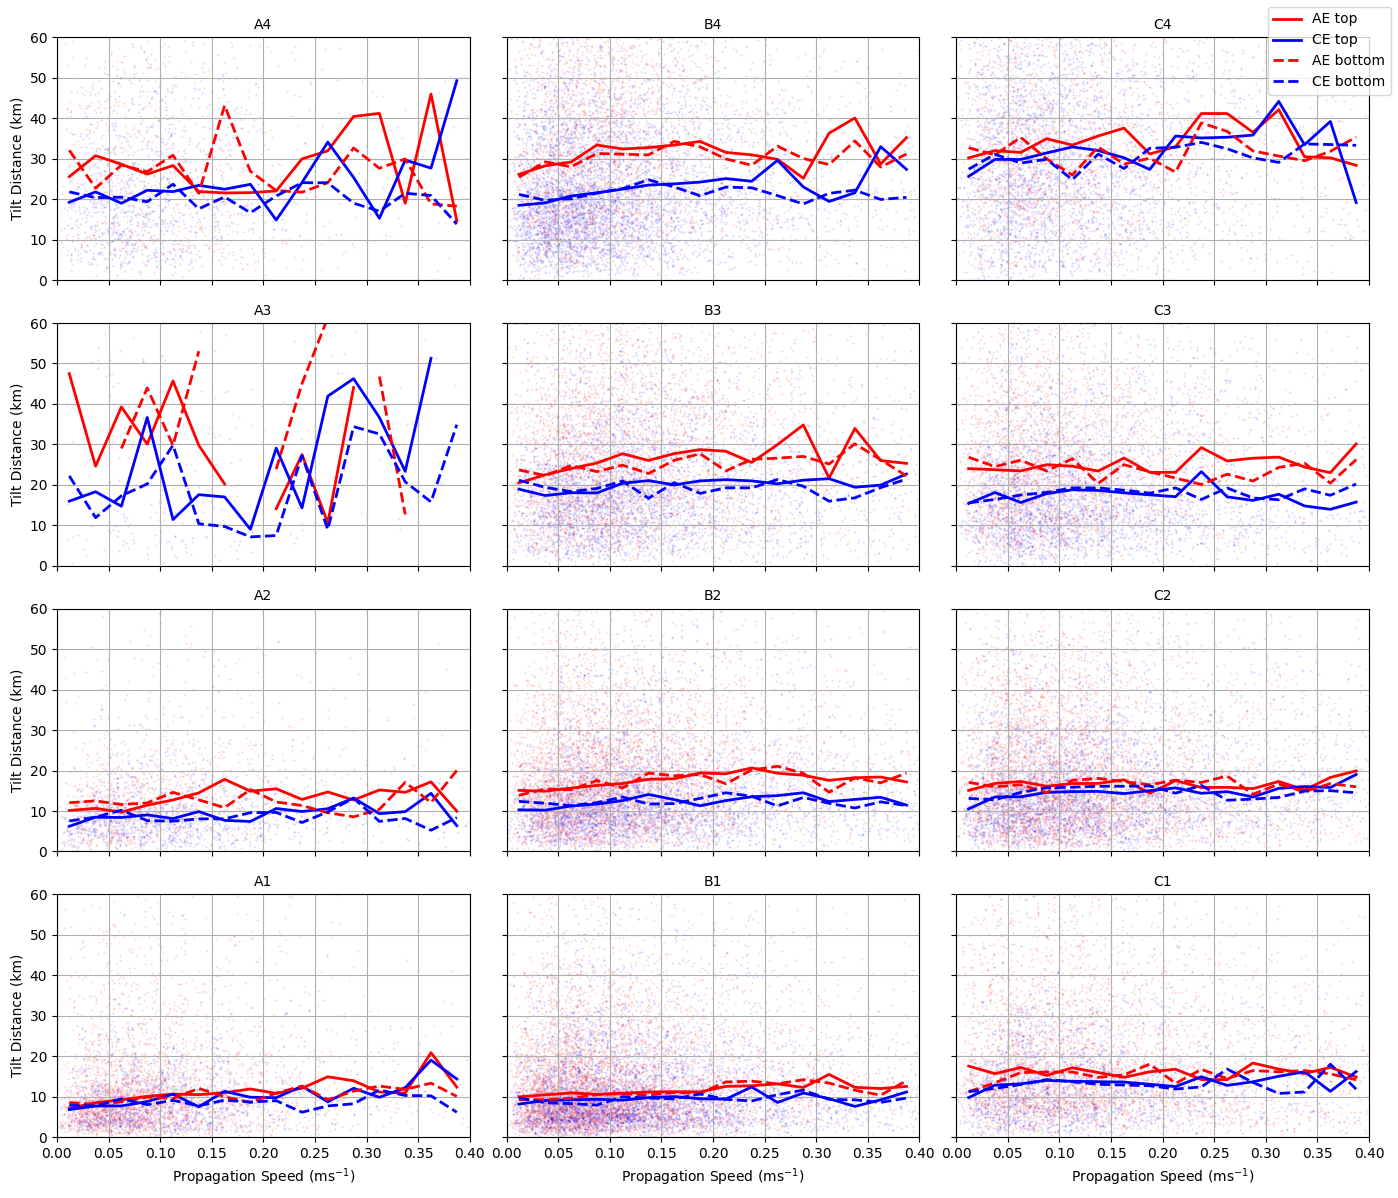

In [17]:
bins = np.arange(0, 0.4 + 0.025, 0.025)

rows = [4, 3, 2, 1]      # top → bottom
cols = ['A', 'B', 'C']   # left → right

fig, axs = plt.subplots(4, 3, figsize=(14, 12), sharex=True, sharey=True)

for i, row in enumerate(rows):
    for j, col in enumerate(cols):
        ax = axs[i, j]
        cell = f"{col}{row}"
        ax.set_title(cell, fontsize=10)

        df_cell = df_eddies[df_eddies.cell_label == cell]

        # ---------- FIRST SET: EddyProp binned vs TiltDis ----------
        for cyc, color in [('AE', 'r'), ('CE', 'b')]:
            df = df_cell[df_cell.Cyc == cyc].copy()
            if df.empty or df['EddyProp'].isna().all():
                continue

            df['bin'] = pd.cut(df['EddyProp'], bins=bins, include_lowest=True)
            mean = df.groupby('bin', observed=False)['TiltDis'].median()
            x = np.array([b.mid for b in mean.index])

            ax.scatter(df['EddyProp'], df['TiltDis'],
                       s=2, alpha=0.1, color=color, marker='.')

            ax.plot(x, mean.values, lw=2,
                    label=f'{cyc} top', color=color, linestyle='-')

        # ---------- SECOND SET: btm_prop binned vs TiltDis (dashed) ----------
        for cyc, color in [('AE', 'r'), ('CE', 'b')]:
            df = df_cell[df_cell.Cyc == cyc].copy()
            if df.empty or df['btm_prop'].isna().all():
                continue

            df['bin'] = pd.cut(df['btm_prop'], bins=bins, include_lowest=True)
            mean = df.groupby('bin', observed=False)['TiltDis'].median()
            x = np.array([b.mid for b in mean.index])

            ax.plot(x, mean.values, lw=2,
                    label=f'{cyc} bottom', color=color, linestyle='--')

        ax.grid(True)
        ax.set_xlim(0, 0.4)
        ax.set_ylim(0, 60)

# x / y labels
for ax in axs[-1, :]:
    ax.set_xlabel(r'Propagation Speed (ms$^{-1}$)')
for ax in axs[:, 0]:
    ax.set_ylabel('Tilt Distance (km)')

# single legend from the first axes that has labels
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

plt.tight_layout()
plt.show()


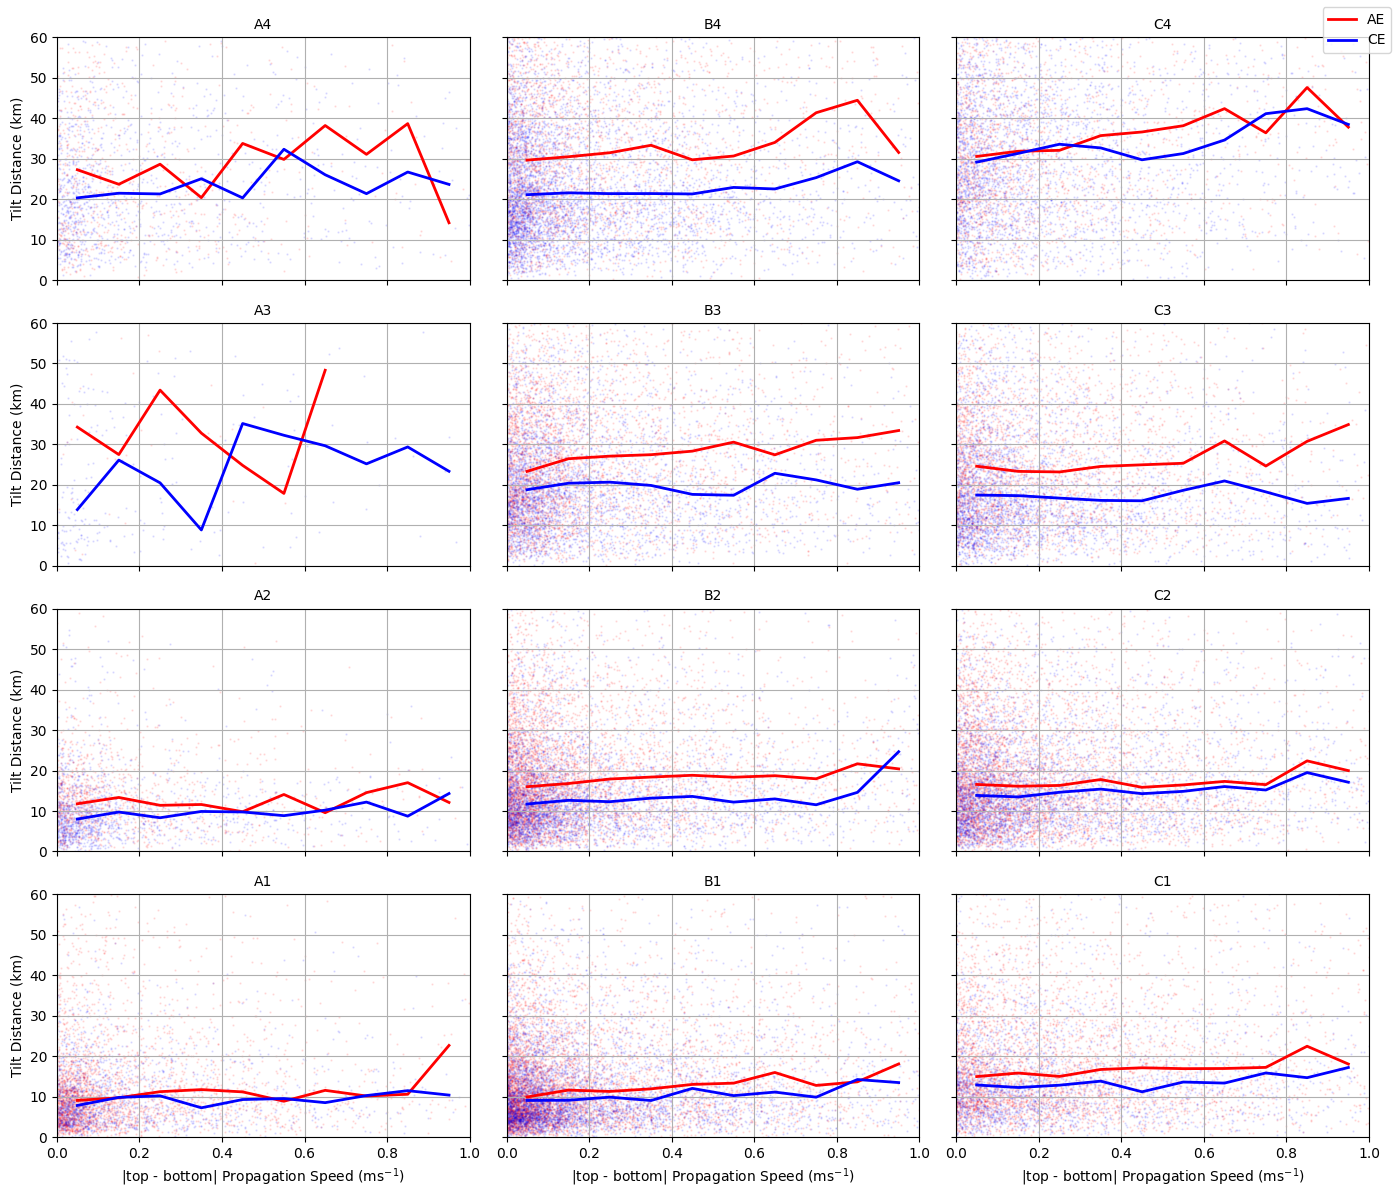

In [18]:
bins = np.arange(0, 1 + 0.1, 0.1)

rows = [4, 3, 2, 1]      # top → bottom
cols = ['A', 'B', 'C']   # left → right

fig, axs = plt.subplots(4, 3, figsize=(14, 12), sharex=True, sharey=True)

for i, row in enumerate(rows):
    for j, col in enumerate(cols):
        ax = axs[i, j]
        cell = f"{col}{row}"
        ax.set_title(cell, fontsize=10)

        df_cell = df_eddies[df_eddies.cell_label == cell]

        # AE (red) and CE (blue)
        for cyc_label, color in [('AE', 'r'), ('CE', 'b')]:

            df = df_cell[df_cell.Cyc == cyc_label].copy()
            if df.empty:
                continue

            # x = |top - bottom propagation|
            diff = np.abs(df.EddyProp - df.btm_prop)
            df['diff'] = diff

            df['bin'] = pd.cut(df['diff'], bins=bins, include_lowest=True)

            # binned median TiltDis
            mean = df.groupby('bin', observed=False)['TiltDis'].median()
            x_mid = np.array([b.mid for b in mean.index])

            # scatter
            ax.scatter(df['diff'], df['TiltDis'], s=2, alpha=0.1,
                       color=color, marker='.')

            # median curve
            ax.plot(x_mid, mean.values, lw=2, color=color, label=cyc_label)

        ax.grid(True)
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 60)

# axis labels
for ax in axs[-1, :]:
    ax.set_xlabel(r'|top - bottom| Propagation Speed (ms$^{-1}$)')
for ax in axs[:, 0]:
    ax.set_ylabel('Tilt Distance (km)')

# single legend
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

plt.tight_layout()
plt.show()


### Vorticity

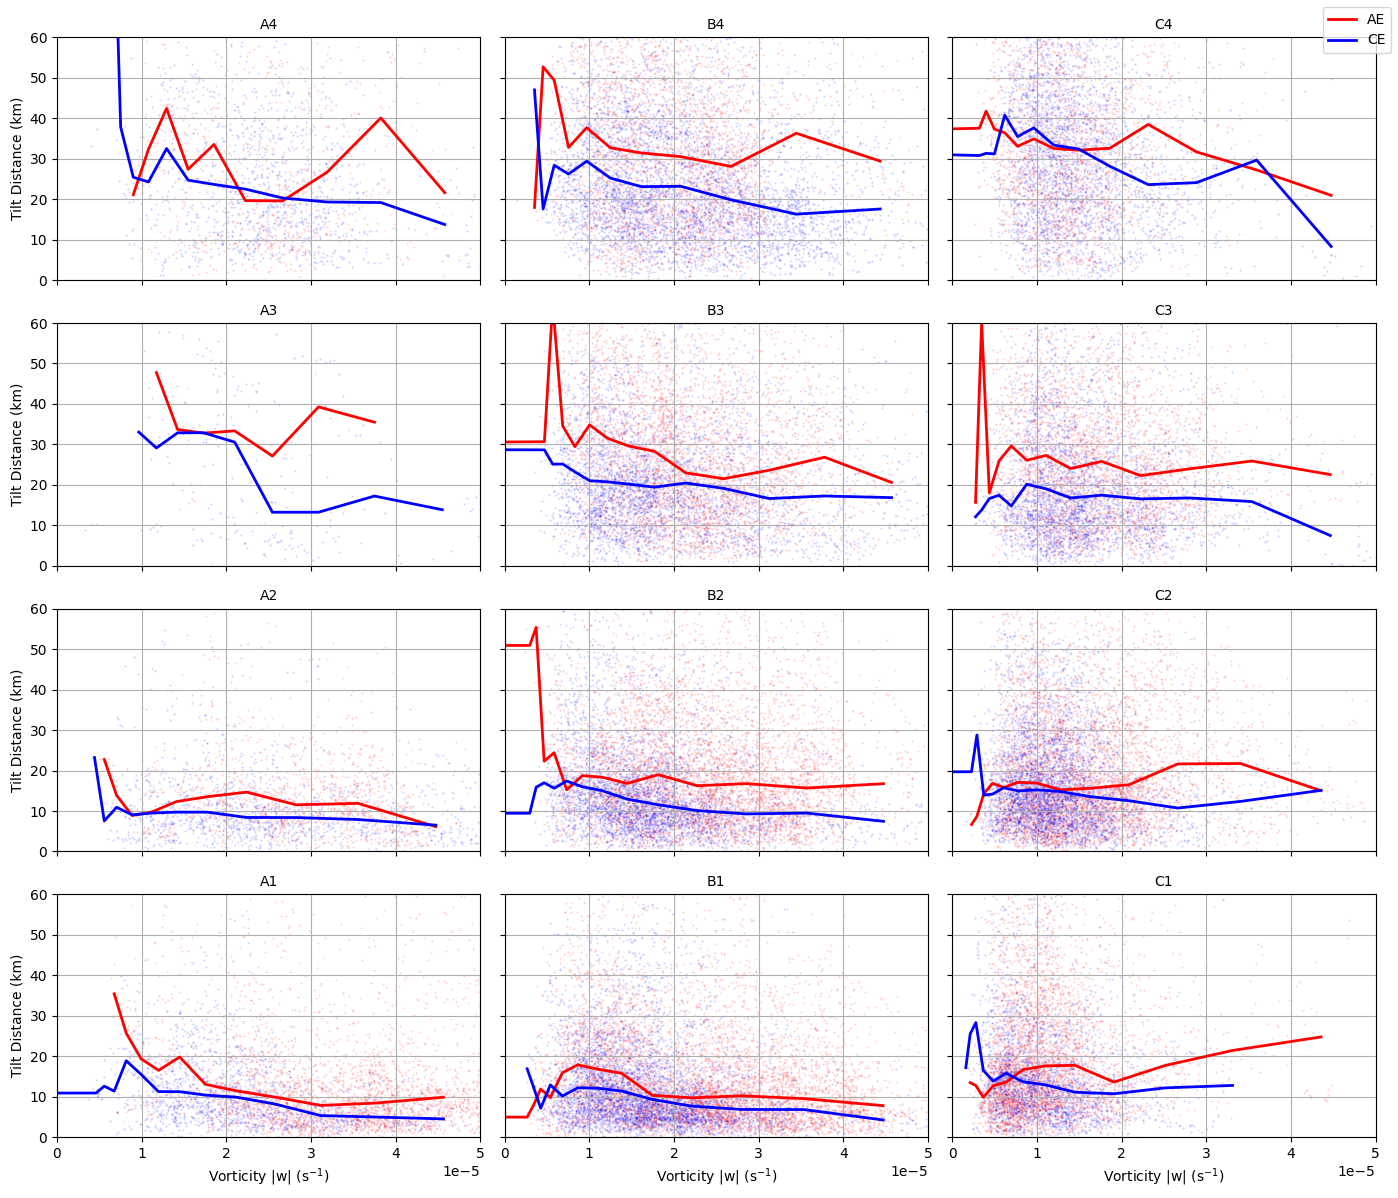

In [19]:
rows = [4, 3, 2, 1]      # top → bottom
cols = ['A', 'B', 'C']   # left → right

fig, axs = plt.subplots(4, 3, figsize=(14, 12), sharex=True, sharey=True)

for i, row in enumerate(rows):
    for j, col in enumerate(cols):
        ax = axs[i, j]
        cell = f"{col}{row}"
        ax.set_title(cell, fontsize=10)

        # restrict to this cell
        df_cell = df_eddies[df_eddies.cell_label == cell].copy()
        df_cell = df_cell[df_cell.w.abs() < 5e-5]   # your global filter

        # compute bins for this cell (log-spaced)
        wvals = df_cell.w.abs()
        wvals = wvals[wvals > 0]     # avoid log10(0)
        if len(wvals) < 5:
            continue

        bins = np.logspace(
            np.log10(wvals.min()),
            np.log10(wvals.max()),
            15
        )

        # AE and CE separately
        for cyc_label, color in [('AE', 'r'), ('CE', 'b')]:

            df = df_cell[df_cell.Cyc == cyc_label].copy()
            if df.empty:
                continue

            w = df.w.abs()
            df['bin'] = pd.cut(w, bins=bins, include_lowest=True)

            # binned median TiltDis
            mean = df.groupby('bin', observed=False)['TiltDis'].median()
            x_mid = np.array([b.mid for b in mean.index])

            # scatter
            ax.scatter(w, df.TiltDis,
                       s=2, alpha=0.12,
                       color=color, marker='.')

            # median curve
            ax.plot(x_mid, mean.values, lw=2,
                    color=color, label=cyc_label)

        ax.set_xscale('linear')
        ax.grid(True)
        ax.set_xlim(0, 5e-5)
        ax.set_ylim(0, 60)

# axis labels
for ax in axs[-1, :]:
    ax.set_xlabel(r'Vorticity |w| (s$^{-1}$)')
for ax in axs[:, 0]:
    ax.set_ylabel('Tilt Distance (km)')

# single legend
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

plt.tight_layout()
plt.show()


### Deformation

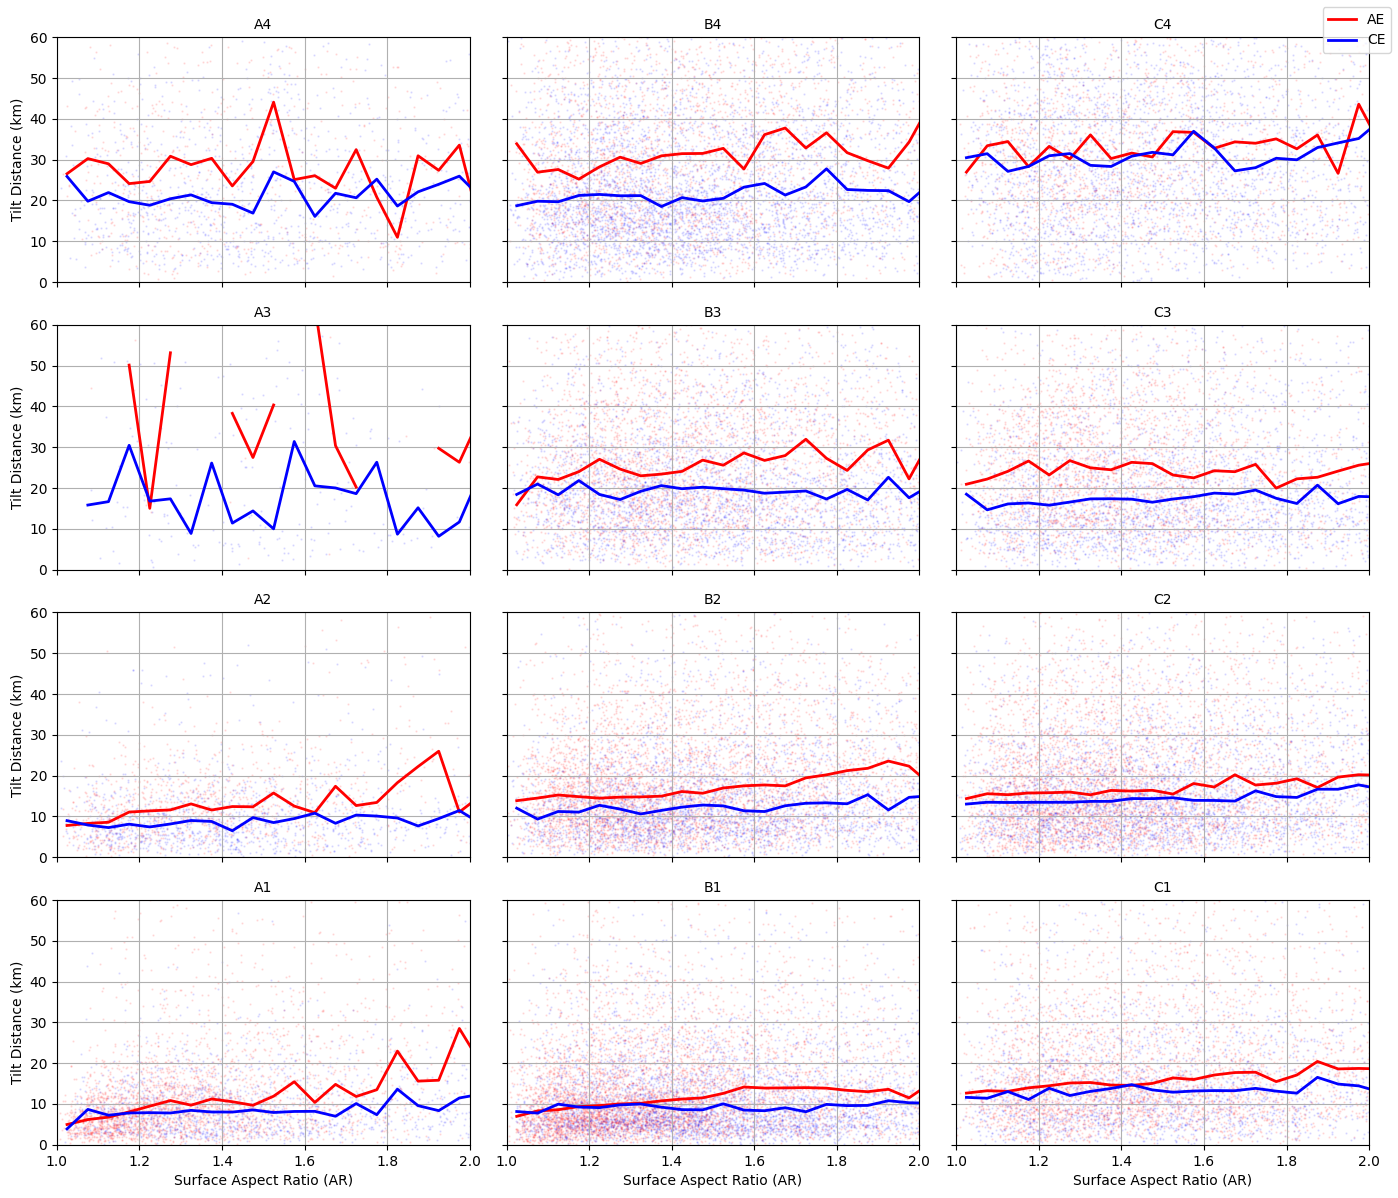

In [20]:
bins = np.arange(1, 3.7, 0.05)

rows = [4, 3, 2, 1]      # top → bottom
cols = ['A', 'B', 'C']   # left → right

fig, axs = plt.subplots(4, 3, figsize=(14, 12), sharex=True, sharey=True)

for i, row in enumerate(rows):
    for j, col in enumerate(cols):
        ax = axs[i, j]
        cell = f"{col}{row}"
        ax.set_title(cell, fontsize=10)

        df_cell = df_eddies[df_eddies.cell_label == cell]

        # AE (red) and CE (blue)
        for cyc_label, color in [('AE', 'r'), ('CE', 'b')]:

            df = df_cell[df_cell.Cyc == cyc_label].copy()
            if df.empty:
                continue

            # filter AR < 3.5
            df = df[df.AR < 3.5].copy()
            if df.empty:
                continue

            df['bin'] = pd.cut(df.AR, bins=bins, include_lowest=True)

            # binned median TiltDis
            mean = df.groupby('bin', observed=False)['TiltDis'].median()
            x_mid = np.array([b.mid for b in mean.index])

            # scatter
            ax.scatter(df.AR, df.TiltDis,
                       s=2, alpha=0.1,
                       color=color, marker='.')

            # median curve
            ax.plot(x_mid, mean.values, lw=2,
                    color=color, label=cyc_label)

        ax.grid(True)
        ax.set_xlim(1, 2)
        ax.set_ylim(0, 60)

# axis labels
for ax in axs[-1, :]:
    ax.set_xlabel('Surface Aspect Ratio (AR)')
for ax in axs[:, 0]:
    ax.set_ylabel('Tilt Distance (km)')

# one legend for all cells
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

plt.tight_layout()
plt.show()



### Bathymetry

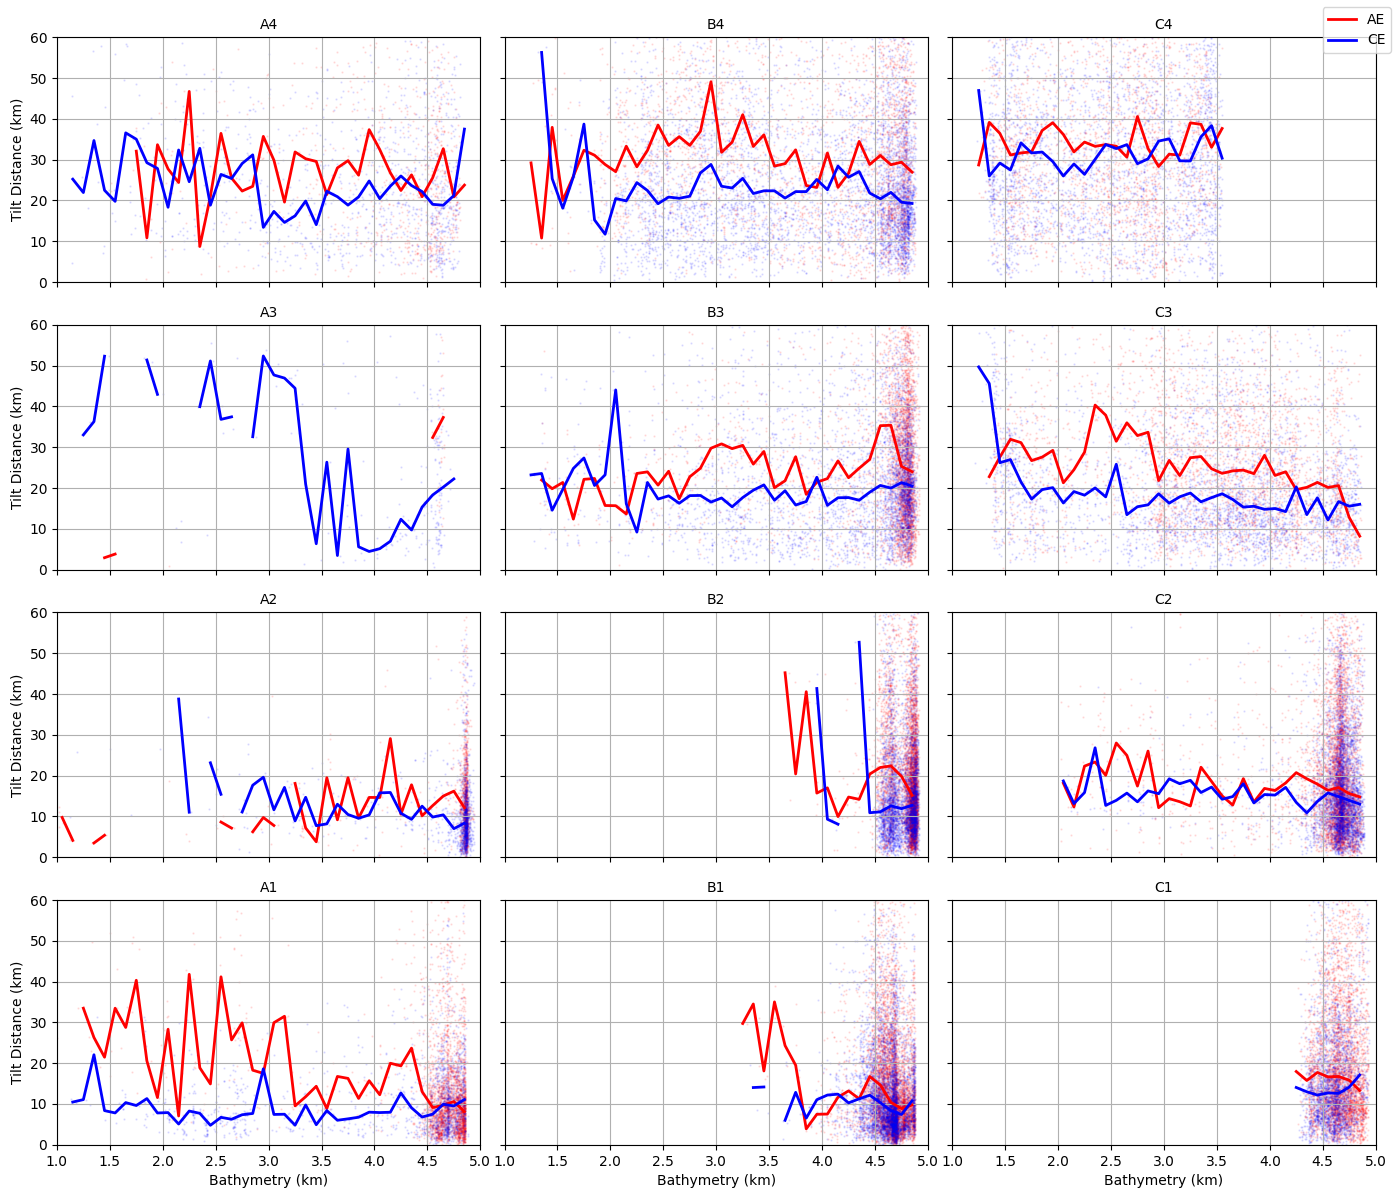

In [21]:
bins = np.arange(1, 5, 0.1)   # <-- manual bins

rows = [4, 3, 2, 1]
cols = ['A', 'B', 'C']

fig, axs = plt.subplots(4, 3, figsize=(14, 12), sharex=True, sharey=True)

for i, row in enumerate(rows):
    for j, col in enumerate(cols):
        ax = axs[i, j]
        cell = f"{col}{row}"
        ax.set_title(cell, fontsize=10)

        df_cell = df_eddies[df_eddies.cell_label == cell]

        for cyc_label, color in [('AE', 'r'), ('CE', 'b')]:

            df = df_cell[df_cell.Cyc == cyc_label].copy()
            if df.empty:
                continue

            df['h_km'] = df.h / 1e3

            # assign bin index using pd.cut  ← IMPORTANT
            df['bin'] = pd.cut(df['h_km'], bins=bins, include_lowest=True)

            # compute binned median
            mean = df.groupby('bin', observed=False)['TiltDis'].median()

            # bin midpoints
            x_mid = np.array([interval.mid for interval in mean.index])

            # scatter
            ax.scatter(df['h_km'], df['TiltDis'],
                       s=2, alpha=0.10, color=color, marker='.')

            # median curve
            ax.plot(x_mid, mean.values, lw=2, color=color, label=cyc_label)

        ax.grid(True)
        ax.set_xlim(1, 5)
        ax.set_ylim(0, 60)

# axis labels
for ax in axs[-1, :]:
    ax.set_xlabel('Bathymetry (km)')
for ax in axs[:, 0]:
    ax.set_ylabel('Tilt Distance (km)')

# shared legend
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

plt.tight_layout()
plt.show()


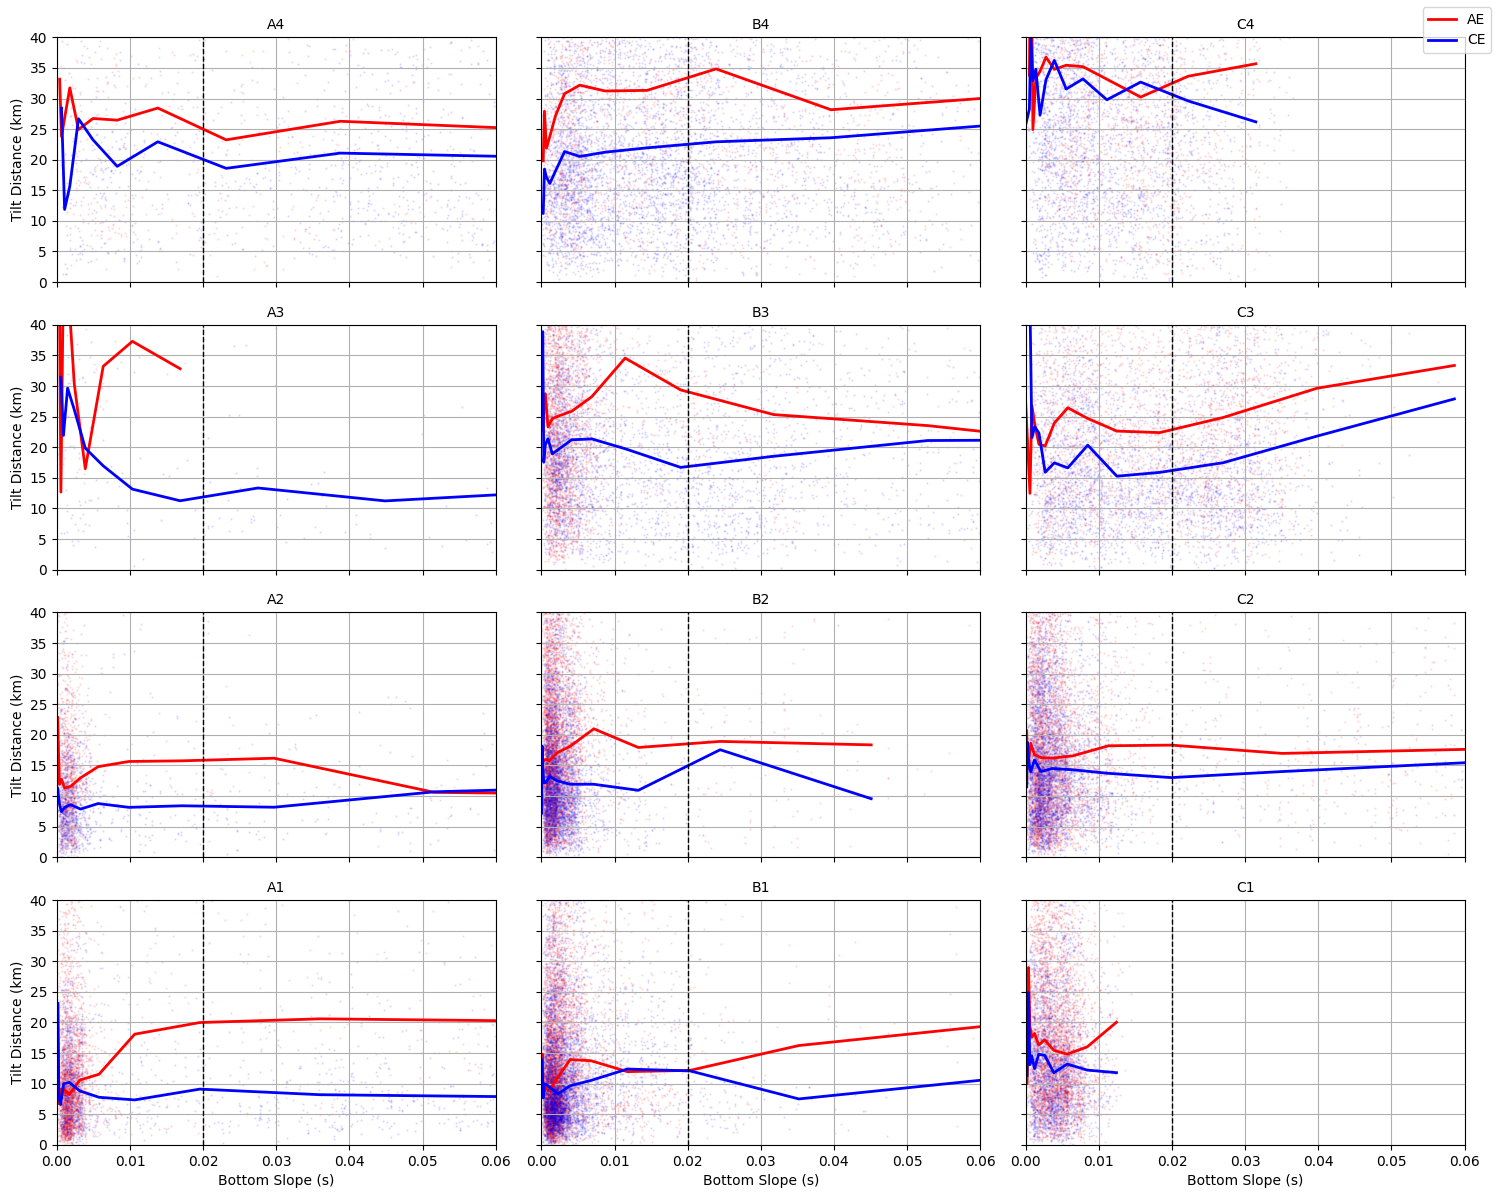

In [22]:
rows = [4, 3, 2, 1]       # top → bottom
cols = ['A', 'B', 'C']    # left → right

fig, axs = plt.subplots(4, 3, figsize=(15, 12), sharex=True, sharey=True)

for i, row in enumerate(rows):
    for j, col in enumerate(cols):
        ax = axs[i, j]
        cell = f"{col}{row}"
        ax.set_title(cell, fontsize=10)

        # restrict to this cell & global filter
        df_cell = df_eddies[df_eddies.cell_label == cell].copy()
        df_cell = df_cell[df_cell.w.abs() < 0.06]

        # bottom slope (positive only for logspace)
        svals = df_cell.s
        svals_pos = svals[svals > 0]

        if len(svals_pos) < 5:
            continue

        # log-spaced bins PER CELL
        bins = np.logspace(
            np.log10(svals_pos.min()),
            np.log10(svals_pos.max()),
            15
        )

        # AE (red) and CE (blue)
        for cyc_label, color in [('AE', 'r'), ('CE', 'b')]:

            df = df_cell[df_cell.Cyc == cyc_label].copy()
            if df.empty:
                continue

            df['bin'] = pd.cut(df.s, bins=bins, include_lowest=True)

            mean = df.groupby('bin', observed=False)['TiltDis'].median()
            x_mid = np.array([b.mid for b in mean.index])

            # scatter
            ax.scatter(df.s, df.TiltDis,
                       s=2, alpha=0.1,
                       color=color, marker='.')

            # median curve
            ax.plot(x_mid, mean.values, lw=2,
                    color=color, label=cyc_label)

        ax.grid(True)
        ax.set_xlim(0, 0.06)
        ax.set_ylim(0, 40)

        # vertical line at s = 0.02
        ax.axvline(0.02, ls='--', color='k', lw=1)

# axis labels
for ax in axs[-1, :]:
    ax.set_xlabel('Bottom Slope (s)')
for ax in axs[:, 0]:
    ax.set_ylabel('Tilt Distance (km)')

# shared legend
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

plt.tight_layout()
plt.show()



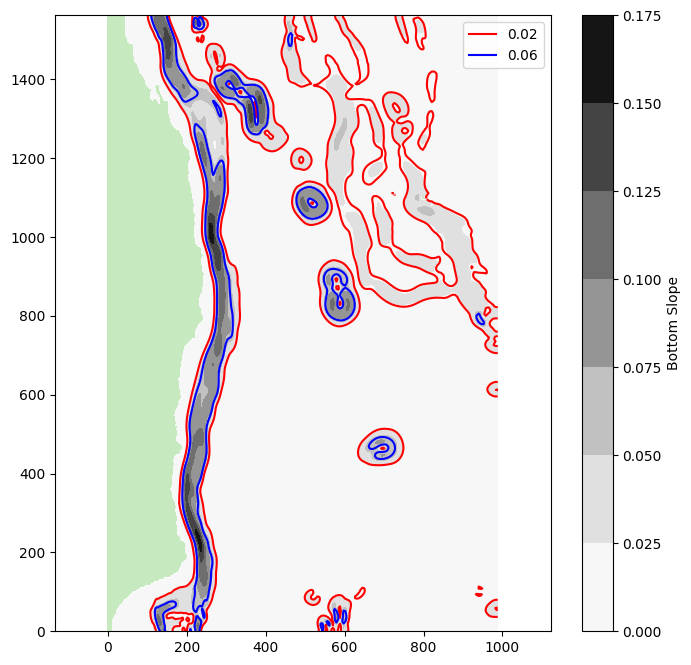

In [23]:
s = slope_mag(h/1e3, X_grid, Y_grid, mask=mask_rho)
plt.figure(figsize=(8,8))
plt.contourf(X_grid, Y_grid, np.where(mask_rho, np.nan, 1), cmap='Greens')
plt.contourf(X_grid, Y_grid, s, cmap='Greys')
plt.colorbar(label='Bottom Slope')
plt.contour(X_grid, Y_grid, s, levels=[.02, .06], colors=['r', 'b'])
plt.plot(np.nan, np.nan, color='r', label=.02)
plt.plot(np.nan, np.nan, color='b', label=.06)
plt.axis('equal'); plt.legend()


### Tilt Direction

In [24]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# --- Tilt Distance ---
axs[0].hist(df_eddies[df_eddies.Cyc == 'AE'].TiltDis.dropna(), bins=100, color='r')
counts, bins = np.histogram(df_eddies[df_eddies.Cyc == 'CE'].TiltDis.dropna(), bins=100)
axs[0].bar(bins[:-1], -counts, width=np.diff(bins), color='b', align='edge')
axs[0].set_ylim(-2200, 2200)
axs[0].axhline(0, color='k', linewidth=1)
axs[0].set_xlabel('Tilt Distance (km)')
axs[0].set_ylabel('Number of Eddy-Days')
yticks = axs[0].get_yticks()
axs[0].set_yticks(yticks)
axs[0].set_yticklabels([abs(int(t)) for t in yticks])

# --- Tilt Direction ---
axs[1].hist(df_eddies[df_eddies.Cyc == 'AE'].TiltDir.dropna(), bins=100, color='r')
counts, bins = np.histogram(df_eddies[df_eddies.Cyc == 'CE'].TiltDir.dropna(), bins=100)
axs[1].bar(bins[:-1], -counts, width=np.diff(bins), color='b', align='edge')
axs[1].set_ylim(-1000, 1000)
axs[1].axhline(0, color='k', linewidth=1)
axs[1].set_xlabel('Tilt Direction (° True North)')
axs[1].set_ylabel('Number of Eddy-Days')
yticks = axs[1].get_yticks()
axs[1].set_yticks(yticks)
axs[1].set_yticklabels([abs(int(t)) for t in yticks])

plt.tight_layout()
plt.show()


In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

ncols, nrows = 3, 4
x_edges = np.linspace(X_grid.min(), X_grid.max(), ncols+1)
y_edges = np.linspace(Y_grid.min(), Y_grid.max(), nrows+1)
cell_w = (X_grid.max() - X_grid.min())/ncols
cell_h = (Y_grid.max() - Y_grid.min())/nrows

dir_bins = np.linspace(0, 360, 9)
mag_bins = [0, 20, 40, 60, 80, np.inf]
n_dirs = len(dir_bins) - 1
angles = np.deg2rad((dir_bins[:-1] + dir_bins[1:]) / 2)
width = 2*np.pi / n_dirs
colors_cmps = [plt.cm.viridis_r(np.linspace(0, 1, len(mag_bins)-1)),
               plt.cm.Reds(np.linspace(0, 1, len(mag_bins)-1)),
               plt.cm.Blues(np.linspace(0, 1, len(mag_bins)-1))]

def windrose_counts(directions, magnitudes):
    if len(directions) == 0: return None
    d = np.digitize(np.mod(directions, 360), dir_bins) - 1
    m = np.digitize(magnitudes, mag_bins) - 1
    c = np.zeros((len(mag_bins)-1, n_dirs))
    for di, mi in zip(d, m):
        if 0 <= di < n_dirs and 0 <= mi < len(mag_bins)-1:
            c[mi, di] += 1
    return c

def add_windrose(ax, x0, y0, c, rmax, colors, frac=0.45, tick_flag=False, title=''):
    if c is None: return
    s = frac * min(cell_w, cell_h)
    iax = ax.inset_axes([x0 - s/2, y0 - s/2, s, s], transform=ax.transData, projection='polar')
    bottom = np.zeros(n_dirs)
    for i in range(len(mag_bins)-1):
        hi = "∞" if np.isinf(mag_bins[i+1]) else f"{mag_bins[i+1]:g}"
        label = f"{mag_bins[i]:g}–{hi}"
        iax.bar(angles, c[i], width, bottom=bottom, edgecolor='k', color=colors[i], label=label)
        bottom += c[i]
    iax.set_theta_zero_location('N')
    iax.set_theta_direction(-1)
    iax.set_rlim(0, rmax)
    if tick_flag:
        iax.legend(title=title, loc='upper right', frameon=False, fontsize=10, title_fontsize=10, bbox_to_anchor=(1.35, .85))
    iax.set_xticks([]); iax.set_yticks([]); iax.set_frame_on(False)
    return iax

# precompute counts per cell + global rmax
def cell_counts(df):
    out, rmax = {}, 0.0
    for i in range(ncols):
        for j in range(nrows):
            x0, x1 = x_edges[i], x_edges[i+1]
            y0, y1 = y_edges[j], y_edges[j+1]
            sub = df[(df.xc >= x0) & (df.xc < x1) & (df.yc >= y0) & (df.yc < y1)]
            d = np.asarray(sub.TiltDir.dropna().values, float)
            m = np.asarray(sub.TiltDis.dropna().values, float)
            n = min(len(d), len(m))
            c = windrose_counts(d[:n], m[:n])
            out[(i,j)] = c
            if c is not None:
                rmax = max(rmax, np.max(c.sum(axis=0)))
    return out, (1 if rmax == 0 else rmax)

fracs = [1.5, 2.0, 1.8]
fig, axs = plt.subplots(1, 3, figsize=(19, 9), sharey=True)
titles = ['Eddy-Days', 'AE-Days', 'CE-Days']
for p, cyc in enumerate(['AE & CE', 'AE', 'CE']):
    ax = axs[p]
    df = df_eddies if cyc == 'AE & CE' else df_eddies[df_eddies.Cyc == cyc]

    ax.contourf(X_grid, Y_grid, np.where(mask_rho == 0, 1, np.nan), levels=[0.5, 1.5], colors=['k'], alpha=.5)
    c1 = ax.contour(X_grid, Y_grid, lat_rho, levels=levels_lat, colors='k', linewidths=.5)
    ax.clabel(c1, fmt=lambda v: f"{np.abs(v):.0f}°S", inline=True, colors='k')
    c2 = ax.contour(X_grid, Y_grid, lon_rho, levels=levels_lon, colors='k', linewidths=.5)
    ax.clabel(c2, fmt=lambda v: f"{v:.0f}°E", inline=True, colors='k')
    ax.axis('equal'); ax.set_xlim(X_grid.min(), X_grid.max()); ax.set_ylim(Y_grid.min(), Y_grid.max())
    ax.contour(X_grid, Y_grid, h, levels=[4000], colors='k'); #ax.set_title(cyc)

    counts_map, rmax = cell_counts(df)
    for i in range(ncols):
        for j in range(nrows):
            x0, x1 = x_edges[i], x_edges[i+1]
            y0, y1 = y_edges[j], y_edges[j+1]
            xc, yc = 0.5*(x0+x1), 0.5*(y0+y1)
            if (i == 2) and (j==3):
                if p == 2:
                    tick_flag = True
            else:
                tick_flag = False

            add_windrose(ax, xc, yc, counts_map[(i,j)], rmax, colors_cmps[p], frac=fracs[p], tick_flag=tick_flag, title=' ' + titles[p] + ':\n Tilt Dist. (km)')
            if (i==0) and (j==2):
                if p == 1:
                    add_windrose(ax, 120, 1130, counts_map[(i,j)], rmax/40, colors_cmps[p], frac=fracs[p])
                else:
                    add_windrose(ax, 120, 1200, counts_map[(i,j)], rmax/10, colors_cmps[p], frac=fracs[p])
            
            ax.plot([x0, x1, x1, x0, x0], [y0, y0, y1, y1, y0], 'k-', lw=.3)

    # column headers above each column
    col_labels = ['A', 'B', 'C', 'D']
    for i in range(ncols):
        xc = 0.5 * (x_edges[i] + x_edges[i+1])
        ax.text(xc, y_edges[-1] + 0.02*(Y_grid.max()-Y_grid.min()),
                col_labels[i], ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    # row headers to the left of each row (counted from bottom)
    for j in range(nrows):
        yc = 0.5 * (y_edges[j] + y_edges[j+1])
        if p == 0:
            alpha = .06
        else:
            alpha = .02
        ax.text(x_edges[0] - alpha*(X_grid.max()-X_grid.min()), yc,
                f"{j+1}", ha='right', va='center', fontsize=12, fontweight='bold')
            
for ax in axs: ax.set_xlabel('x (km)')
axs[0].set_ylabel('y (km)')
plt.tight_layout(); plt.show()


### Where is tilt not being measured?

In [ ]:
df_nt = df_eddies[np.isnan(df_eddies.TiltDis)].copy()
df_nt = df_nt[(np.abs(df_nt.Day_idx-(df_nt.Age-1)) > 2) & (df_nt.Day_idx > 2)]

fig, axs = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)

cmaps = ['Greens', 'Reds', 'Blues']
labels = ['Eddy-Day Count', 'AE-Day Count', 'CE-Day Count']
# --- Panel 2 & 3: Eddy-day distributions ---
for d, subset in enumerate([df_nt, df_nt[df_nt.Cyc == 'AE'], df_nt[df_nt.Cyc == 'CE']]):
    eddy_x = subset.xc
    eddy_y = subset.yc
    
    bin_km = 50
    x_edges = np.arange(X_grid.min(), X_grid.max() + bin_km, bin_km)
    y_edges = np.arange(Y_grid.min(), Y_grid.max() + bin_km, bin_km)
    
    H, _, _ = np.histogram2d(eddy_y, eddy_x, bins=[y_edges, x_edges])
    
    pcm = axs[d].pcolormesh(x_edges, y_edges, H, cmap=cmaps[d])
    fig.colorbar(pcm, ax=axs[d], label=labels[d])
    
    axs[d].contourf(X_grid, Y_grid, np.where(mask_rho == 0, 1, np.nan),
                      levels=[0.5, 1.5], colors=['k'], alpha=.5)

    c1 = axs[d].contour(X_grid, Y_grid, lat_rho, levels=[-40, -35, -30, -25],
                          colors='k', linewidths=.5)
    axs[d].clabel(c1, fmt=lambda v: f"{np.abs(v):.0f}°S", inline=True, colors='k')
    c2 = axs[d].contour(X_grid, Y_grid, lon_rho, levels=[150, 155, 160],
                          colors='k', linewidths=.5)
    axs[d].clabel(c2, fmt=lambda v: f"{v:.0f}°E", inline=True, colors='k')
    
    axs[d].set_xlabel('x (km)')
    axs[d].set_ylabel('y (km)')
    axs[d].set_aspect('equal')

    axs[d].contour(X_grid, Y_grid, h, levels=[4000], colors='k')

# plt.tight_layout()
plt.show()


In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

ncols, nrows = 3, 4
x_edges = np.linspace(X_grid.min(), X_grid.max(), ncols+1)
y_edges = np.linspace(Y_grid.min(), Y_grid.max(), nrows+1)
cell_w = (X_grid.max() - X_grid.min())/ncols
cell_h = (Y_grid.max() - Y_grid.min())/nrows

def cell_counts_valid_invalid(df):
    out, vmax = {}, 0
    for i in range(ncols):
        for j in range(nrows):
            x0, x1 = x_edges[i], x_edges[i+1]
            y0, y1 = y_edges[j], y_edges[j+1]
            sub = df[(df.xc >= x0) & (df.xc < x1) & (df.yc >= y0) & (df.yc < y1)]
            v = np.count_nonzero(~sub.TiltDis.isna())
            sub_excluding_beg_end = sub[(np.abs(sub.Day_idx-(sub.Age-1)) > 2) & (sub.Day_idx > 2)]
            iv = np.count_nonzero(sub_excluding_beg_end.TiltDis.isna())
            c = np.array([v, iv], dtype=int)
            out[(i,j)] = c
            vmax = max(vmax, v)  # <— track max valid only
    return out, (1 if vmax == 0 else vmax)

def make_autopct(vals):
    total = np.sum(vals)
    def _inner(pct):
        v = int(round(pct*total/100.0))
        return f"{v}" if v > 0 else ""
    return _inner

def add_pie_valid_invalid(ax, x0, y0, counts, tmax, frac=0.25, tick_flag=False, title='', color=plt.cm.Greens(0.6)):
    if counts is None or counts.sum() == 0: return
    s_base = frac * min(cell_w, cell_h)
    scale = 0.35 + 0.65 * (counts[0] / tmax)  # <— use valid only
    s = s_base * scale
    iax = ax.inset_axes([x0 - s/2, y0 - s/2, s, s], transform=ax.transData)
    iax.pie(counts, startangle=90, counterclock=False,
            colors=[color, plt.cm.Greys(0.55)],
            wedgeprops={'edgecolor':'k','linewidth':0.3},
            autopct=make_autopct(counts), pctdistance=0.65,
            textprops={'fontsize':12, 'fontweight': 'bold'})
    iax.set_aspect('equal'); iax.set_xticks([]); iax.set_yticks([])
    for spine in iax.spines.values(): spine.set_visible(False)
    if tick_flag:
        ax.legend(handles=[
            plt.Line2D([0],[0], marker='o', linestyle='', markerfacecolor=color,
                       markeredgecolor='k', markersize=10, label='Valid Tilt'),
            plt.Line2D([0],[0], marker='o', linestyle='', markerfacecolor=plt.cm.Greys(0.55),
                       markeredgecolor='k', markersize=10, label='Invalid Tilt')],
            loc='upper right', frameon=False, fontsize=12, bbox_to_anchor=(1.35, .9),
            title=title, title_fontsize=12)

fracs = [1.2, 1.2, 1.2]
fig, axs = plt.subplots(1, 3, figsize=(20, 9), sharey=True)
colors = [plt.cm.Greens(0.6), plt.cm.Reds(0.6), plt.cm.Blues(0.6)]
titles = ['Eddy-Days', 'AE-Days', 'CE-Days']
for p, cyc in enumerate(['AE & CE', 'AE', 'CE']):
    ax = axs[p]
    df = df_eddies if cyc == 'AE & CE' else df_eddies[df_eddies.Cyc == cyc]

    ax.contourf(X_grid, Y_grid, np.where(mask_rho == 0, 1, np.nan), levels=[0.5, 1.5], colors=['k'], alpha=.5)
    c1 = ax.contour(X_grid, Y_grid, lat_rho, levels=levels_lat, colors='k', linewidths=.5)
    ax.clabel(c1, fmt=lambda v: f"{np.abs(v):.0f}°S", inline=True, colors='k')
    c2 = ax.contour(X_grid, Y_grid, lon_rho, levels=levels_lon, colors='k', linewidths=.5)
    ax.clabel(c2, fmt=lambda v: f"{v:.0f}°E", inline=True, colors='k')
    ax.axis('equal'); ax.set_xlim(X_grid.min(), X_grid.max()); ax.set_ylim(Y_grid.min(), Y_grid.max())
    ax.contour(X_grid, Y_grid, h, levels=[4000], colors='k')

    counts_map, tmax = cell_counts_valid_invalid(df)
    for i in range(ncols):
        for j in range(nrows):
            x0, x1 = x_edges[i], x_edges[i+1]
            y0, y1 = y_edges[j], y_edges[j+1]
            xc, yc = 0.5*(x0+x1), 0.5*(y0+y1)
            tick_flag = (i == 2 and j == 3)
            add_pie_valid_invalid(ax, xc, yc, counts_map[(i,j)], tmax, frac=fracs[p],
                                  tick_flag=tick_flag, color=colors[p], title=f'{titles[p]}:')
            ax.plot([x0, x1, x1, x0, x0], [y0, y0, y1, y1, y0], 'k-', lw=.3)

    col_labels = ['A', 'B', 'C', 'D']
    for i in range(ncols):
        xc = 0.5 * (x_edges[i] + x_edges[i+1])
        ax.text(xc, y_edges[-1] + 0.02*(Y_grid.max()-Y_grid.min()),
                col_labels[i], ha='center', va='bottom', fontsize=12, fontweight='bold')

    for j in range(nrows):
        yc = 0.5 * (y_edges[j] + y_edges[j+1])
        alpha = .06 if p == 0 else .02
        ax.text(x_edges[0] - alpha*(X_grid.max()-X_grid.min()), yc,
                f"{j+1}", ha='right', va='center', fontsize=12, fontweight='bold')

for ax in axs: ax.set_xlabel('x (km)', fontsize=11)
axs[0].set_ylabel('y (km)', fontsize=11)
plt.tight_layout(); plt.show()


In [ ]:
len(df_eddies)

In [ ]:
df_valid = df_eddies[(np.abs(df_eddies.Day_idx-(df_eddies.Age-1)) > 2) & (df_eddies.Day_idx > 2)].copy()
len(df_valid[~df_valid.TiltDis.isna()])/ len(df_valid)

In [ ]:
len(df_valid[~df_valid.TiltDis.isna()])

In [ ]:
len(df_valid)
